In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=4f353157755a59bebd53becdab417c2759ab14e963e6e70612928d57e398fed6
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for absl-py: filename=absl_py-0.7.1-cp36-none-any.whl size=113722 sha256=1a4003769dc3b032011b2f918fd2764b25637aba69a03cbca2be16a043077ae5
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=982763439a54eb80e08fa682da0a9d3578db09d94eae67a501e2acf74e682bbe
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=588c5c1cd1a3bde872718dd41cd5d50b77d94702adf09639e998419ef3de799

ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\wangmi94\appdata\roaming\python\python36\site-packages (1.17.1)


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.advanced_activations import PReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as skm, math
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Py

# Model Building

## Load data and do data normalization

In [2]:
def moneyness(S,X):
    return S/X

In [3]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [4]:
def load_data(file):
    df = pd.read_csv(file)
    df = df.dropna()
    
    # Remove the option data has less than 7 days to maturity.
    df = df[df.maturity > 6]
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    df = df[df.moneyness >= 0.5]
    df = df[df.moneyness <= 1.5]
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    sample_df = df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    sample_df = sample_df.reset_index(drop=True)
    
    ITM_df = sample_df[sample_df['moneyness'] <= 0.97]
    ATM_df = sample_df[sample_df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = sample_df[sample_df['moneyness'] >= 1.03]
    
    return sample_df, ITM_df, ATM_df, OTM_df

In [5]:
sample_df, ITM_df, ATM_df, OTM_df = load_data('Options_R_new.csv')

In [6]:
print('option data shape:', sample_df.shape)
print('In-The_Money option data shape:', ITM_df.shape)
print('An-The_Money option data shape:', ATM_df.shape)
print('Out-The_Money option data shape:', OTM_df.shape)

option data shape: (1700235, 11)
In-The_Money option data shape: (687300, 11)
An-The_Money option data shape: (262052, 11)
Out-The_Money option data shape: (750883, 11)


In [7]:
def get_corr(sample_df):
    corr_matrix = sample_df.corr()
    
    fig = plt.figure(figsize = (10,10))
    sns.heatmap(corr_matrix, vmax = .8, square = True)
    plt.show()
    
    corr = corr_matrix['best_offer'].sort_values(ascending=False)
    print(corr)
    
    return corr

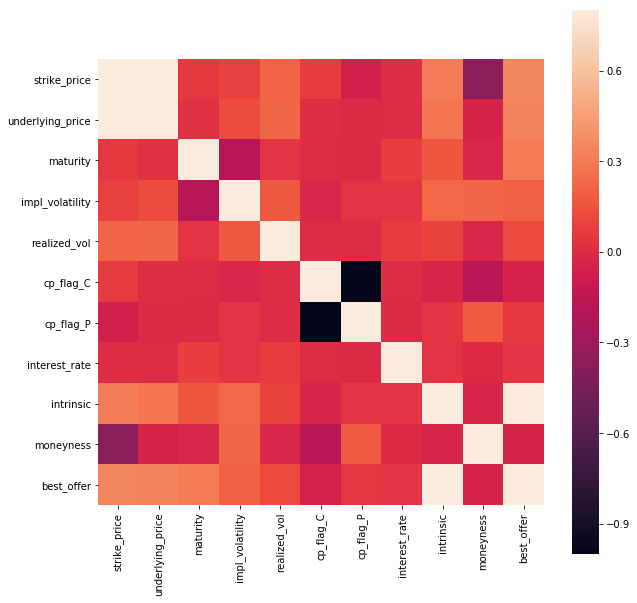

best_offer          1.000000
intrinsic           0.976694
strike_price        0.345604
underlying_price    0.332923
maturity            0.301267
impl_volatility     0.196128
realized_vol        0.118990
cp_flag_P           0.047227
interest_rate       0.038505
moneyness          -0.038097
cp_flag_C          -0.047227
Name: best_offer, dtype: float64


In [8]:
corr = get_corr(sample_df)

In [9]:
def data(s_df):
    
    y = s_df['best_offer'].values
    X = s_df[['intrinsic', 'strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
    y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test#, sc_X, sc_y

## Build model with in-the-money option data

In [10]:
X_train_ITM, X_test_ITM, y_train_ITM, y_test_ITM = data(ITM_df)

In [11]:
print(X_train_ITM[:10])
print(y_test_ITM[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
1616882       0.00         111.0            102.84        16         0.173117   
1010909       0.00         110.0             81.56       309         0.194168   
677456        9.84         170.0            160.16       148         0.166219   
581542        0.00          50.0             41.41        15         0.388734   
456810        0.00         120.0             92.88       180         0.193109   
1282233      15.99         207.5            191.51        35         0.227236   
717418        0.00         235.0            184.04        10         0.547157   
1346286      20.31         225.0            204.69       165         0.172871   
562445        2.97          45.0             42.03         7         0.296552   
317422        0.00         100.0             96.13       172         0.141775   

         cp_flag_P  interest_rate  
1616882          0         0.0001  
1010909          0         0.0003  


In [12]:
# Because it is a simple regression problem, we should custom metrics function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def ABS(x):
    return K.abs(x)

def exp(x):
    return K.exp(x)

In [13]:
def create_model(X, y):#neurons_1=1,learn_rate=0.01):
    
    model = Sequential()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto')
    
    model.add(Dense(50, input_shape = (7,), activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(300, activation = 'elu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(100, activation = 'elu'))
    model.add(Dense(1, activation = 'linear'))
    
    #optimizer = Adam()
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
    
    result = model.fit(X,y, epochs = 200, batch_size = 1024, validation_split = 0.1, verbose = 1, callbacks = [es])
    
    # plot training curve for rmse
    plt.figure(figsize = (14, 10))
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('Loss(mse) converge')
    plt.ylabel('Loss(mse)')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    return model, result

W0827 12:18:41.569875  9716 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 12:18:41.584886  9716 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 12:18:41.586871  9716 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 12:18:41.647915  9716 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

Train on 494856 samples, validate on 54984 samples
Epoch 1/200
494856/494856 [==============================] - 9s 18us/step - loss: 12.3992 - mean_absolute_error: 1.1589 - val_loss: 0.7422 - val_mean_absolute_error: 0.5073
Epoch 2/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.6624 - mean_absolute_error: 0.5101 - val_loss: 0.4941 - val_mean_absolute_error: 0.3931
Epoch 3/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.5890 - mean_absolute_error: 0.4764 - val_loss: 0.8129 - val_mean_absolute_error: 0.6236
Epoch 4/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.4850 - mean_absolute_error: 0.4232 - val_loss: 0.4057 - val_mean_absolute_error: 0.3840
Epoch 5/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.4340 - mean_absolute_error: 0.3997 - val_loss: 0.3811 - val_mean_absolute_error: 0.3815
Epoch 6/200
494856/494856 [==============================] - 8s 16us/step - loss: 0.4117

494856/494856 [==============================] - 8s 17us/step - loss: 0.2224 - mean_absolute_error: 0.2599 - val_loss: 0.2075 - val_mean_absolute_error: 0.2562
Epoch 49/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.2090 - mean_absolute_error: 0.2508 - val_loss: 0.1753 - val_mean_absolute_error: 0.2259
Epoch 50/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.2047 - mean_absolute_error: 0.2482 - val_loss: 0.2404 - val_mean_absolute_error: 0.2598
Epoch 51/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.2063 - mean_absolute_error: 0.2486 - val_loss: 0.2541 - val_mean_absolute_error: 0.2623
Epoch 52/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1975 - mean_absolute_error: 0.2440 - val_loss: 0.3767 - val_mean_absolute_error: 0.3528
Epoch 53/200
494856/494856 [==============================] - 9s 17us/step - loss: 0.1956 - mean_absolute_error: 0.2426 - val_loss: 0.2042 - val_mea

494856/494856 [==============================] - 8s 17us/step - loss: 0.1344 - mean_absolute_error: 0.1998 - val_loss: 0.1194 - val_mean_absolute_error: 0.1913
Epoch 96/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1359 - mean_absolute_error: 0.2014 - val_loss: 0.1223 - val_mean_absolute_error: 0.1918
Epoch 97/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1449 - mean_absolute_error: 0.2079 - val_loss: 0.1106 - val_mean_absolute_error: 0.1800
Epoch 98/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1279 - mean_absolute_error: 0.1940 - val_loss: 0.1848 - val_mean_absolute_error: 0.2589
Epoch 99/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1378 - mean_absolute_error: 0.2020 - val_loss: 0.1046 - val_mean_absolute_error: 0.1688
Epoch 100/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1363 - mean_absolute_error: 0.2006 - val_loss: 0.1159 - val_me

494856/494856 [==============================] - 8s 17us/step - loss: 0.1129 - mean_absolute_error: 0.1819 - val_loss: 0.0976 - val_mean_absolute_error: 0.1653
Epoch 143/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1172 - mean_absolute_error: 0.1852 - val_loss: 0.1255 - val_mean_absolute_error: 0.1872
Epoch 144/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1220 - mean_absolute_error: 0.1897 - val_loss: 0.1138 - val_mean_absolute_error: 0.1841
Epoch 145/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1250 - mean_absolute_error: 0.1919 - val_loss: 0.2079 - val_mean_absolute_error: 0.2485
Epoch 146/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1207 - mean_absolute_error: 0.1875 - val_loss: 0.1137 - val_mean_absolute_error: 0.1806
Epoch 147/200
494856/494856 [==============================] - 8s 17us/step - loss: 0.1130 - mean_absolute_error: 0.1816 - val_loss: 0.1306 - va

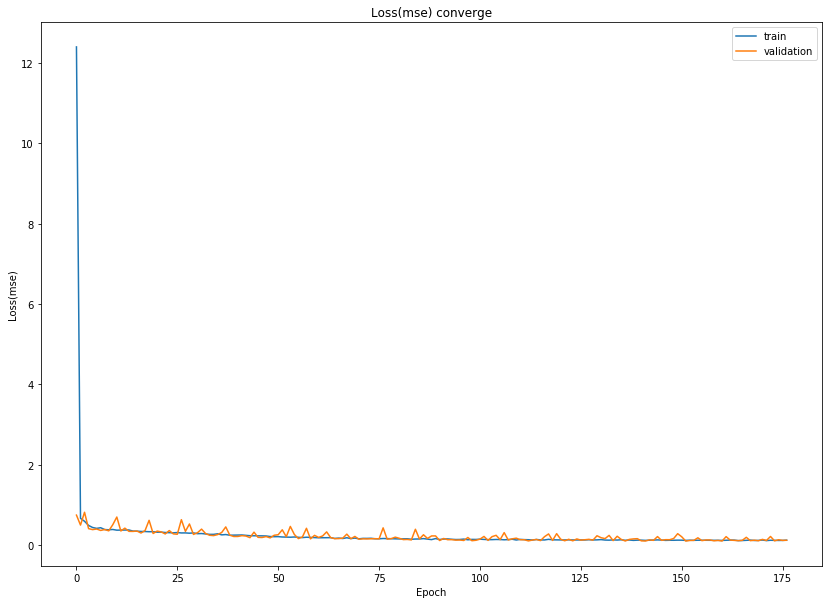

Wall time: 24min 58s


In [14]:
%time model_ITM, result_ITM = create_model(X_train_ITM, y_train_ITM)

In [26]:
def pred(model, X, y):
    
    pred = model.predict(X)

#     pred = sc_y.inverse_transform(pred)
#     y = sc_y.inverse_transform(y)

    pred = pred.flatten()
    y = y.flatten()

    d = {'predicted': pred, 'actual': y}
    pred_df = pd.DataFrame(data = d)
    display(pred_df.head(10))

    pred_sample = pred_df.sample(n = 150)

    pred_sample.sort_index(axis = 0, inplace = True)
    
    plt.figure(1, figsize = (15,10))
    plt.plot(pred_sample.index, pred_sample['predicted'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(pred_sample.index, pred_sample['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    
    l,binEdges=np.histogram(np.abs(pred_sample['predicted']-pred_sample['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
#     print(binEdges)
#     bincenters = binEdges[1:]+binEdges[:-1]
#     print(bincenters)
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
    
        
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist((pred_df['predicted']-pred_df['actual']), 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    plt.grid(True)
    plt.ylim(0,1)
    plt.show()
    #print('The percentage of abs error less than 1:', CountPairsPrecent(pred_sample['predicted'], pred_sample['actual'], len(pred_sample)))
    #plt.plot(pred_sample.index, np.abs(pred_sample['predicted']-pred_sample['actual']), linestyle = '-', label = 'predicted', color = 'r')
    print('\n')
    print("Mean absolute error (MAE): %f" % skm.mean_absolute_error(y,pred))
    print("Mean squared error (MSE):  %f" % skm.mean_squared_error(y,pred))
    print("R square (R^2):            %f" % skm.r2_score(y,pred))

,predicted,actual
0,0.279169,0.27
1,0.357450,0.47
2,30.649239,30.20
3,8.161015,7.75
4,0.048928,0.05
5,0.481500,0.50
6,0.114519,0.10
7,7.384201,7.05
8,0.198706,0.13
9,0.119823,0.11


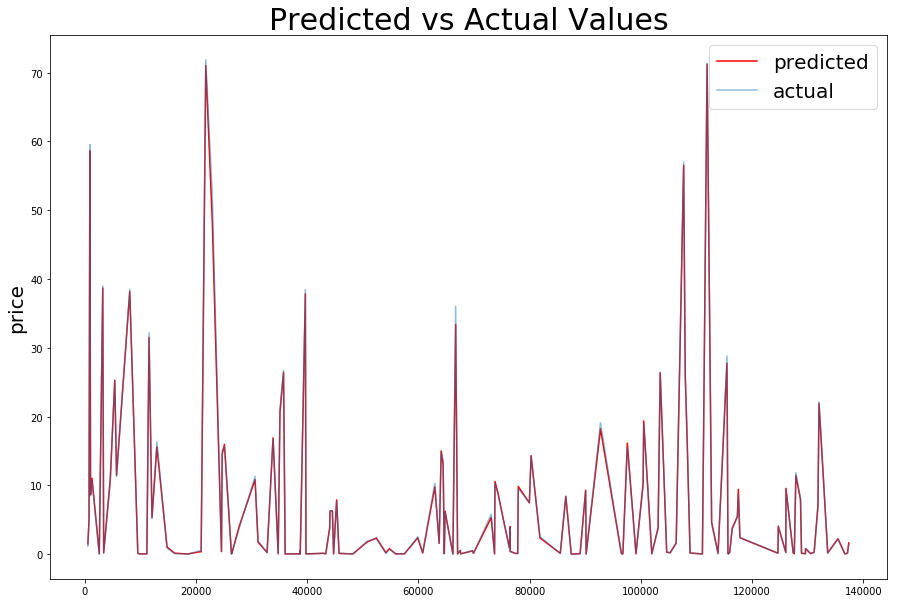

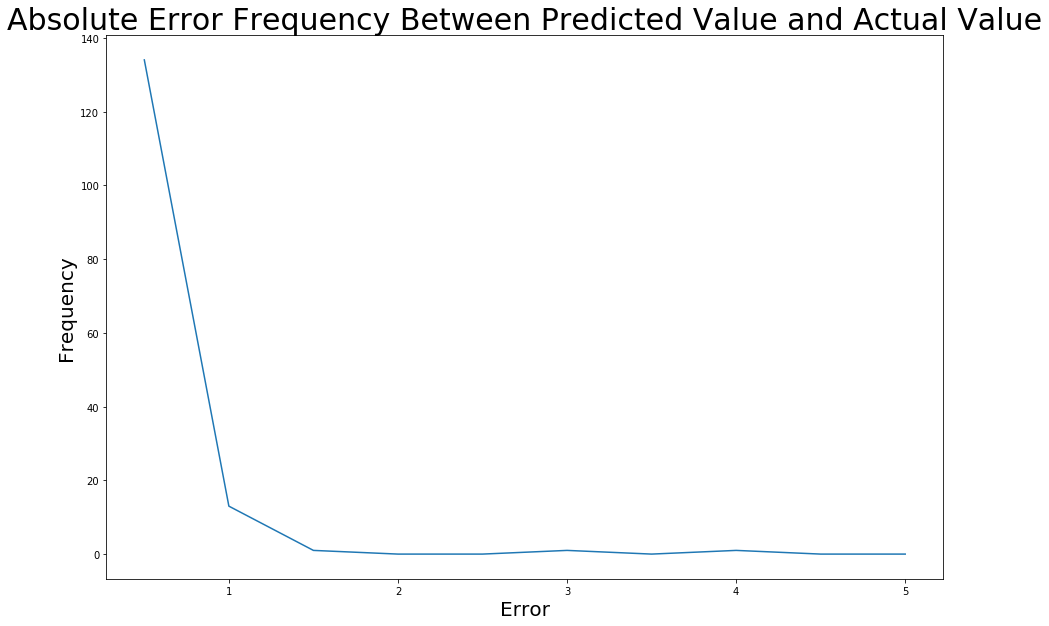

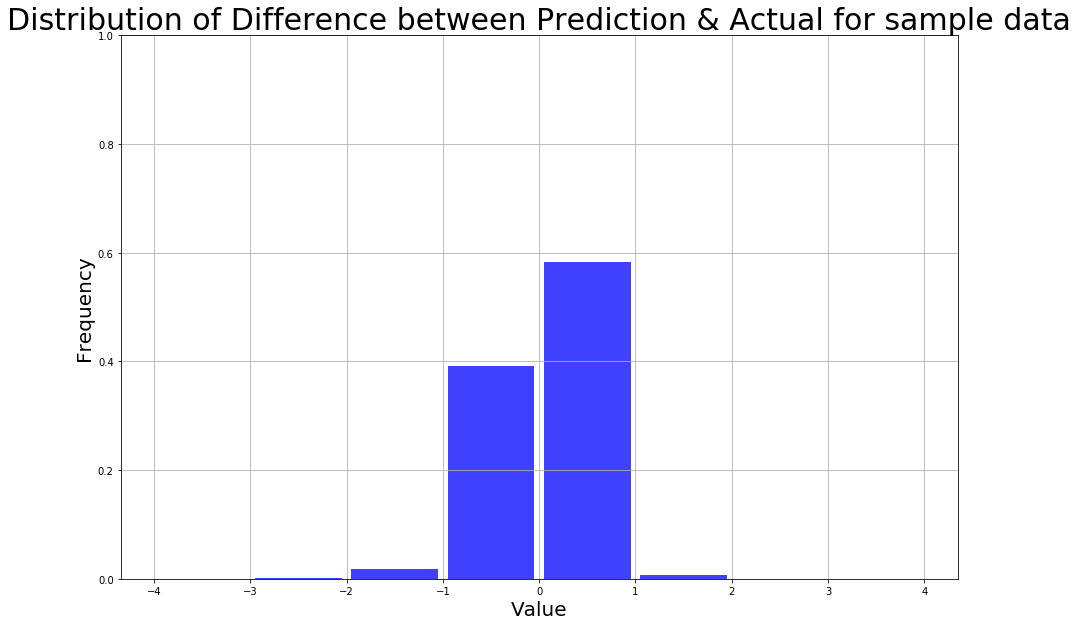



Mean absolute error (MAE): 0.182813
Mean squared error (MSE):  0.115028
R square (R^2):            0.999478


In [27]:
pred_ITM = pred(model_ITM, X_test_ITM, y_test_ITM)

In [17]:
model_ITM.save('model4_2_ITM_ori.h5')

## Build model with at-the-money option data

In [18]:
X_train_ATM, X_test_ATM, y_train_ATM, y_test_ATM = data(ATM_df)

Train on 188676 samples, validate on 20965 samples
Epoch 1/200
188676/188676 [==============================] - 4s 20us/step - loss: 12.5543 - mean_absolute_error: 1.5137 - val_loss: 1.2730 - val_mean_absolute_error: 0.7950
Epoch 2/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.9359 - mean_absolute_error: 0.6316 - val_loss: 0.9040 - val_mean_absolute_error: 0.6553
Epoch 3/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.7896 - mean_absolute_error: 0.5651 - val_loss: 0.8834 - val_mean_absolute_error: 0.6567
Epoch 4/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.7315 - mean_absolute_error: 0.5482 - val_loss: 0.7932 - val_mean_absolute_error: 0.5941
Epoch 5/200
188676/188676 [==============================] - 3s 18us/step - loss: 0.7175 - mean_absolute_error: 0.5466 - val_loss: 0.6172 - val_mean_absolute_error: 0.4949
Epoch 6/200
188676/188676 [==============================] - 3s 17us/step - loss: 0.6267

188676/188676 [==============================] - 3s 16us/step - loss: 0.2479 - mean_absolute_error: 0.2768 - val_loss: 0.1684 - val_mean_absolute_error: 0.2062
Epoch 49/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2560 - mean_absolute_error: 0.2850 - val_loss: 0.1659 - val_mean_absolute_error: 0.2003
Epoch 50/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2401 - mean_absolute_error: 0.2696 - val_loss: 0.2465 - val_mean_absolute_error: 0.3085
Epoch 51/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2396 - mean_absolute_error: 0.2714 - val_loss: 0.2375 - val_mean_absolute_error: 0.3038
Epoch 52/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2599 - mean_absolute_error: 0.2812 - val_loss: 0.5261 - val_mean_absolute_error: 0.4363
Epoch 53/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.2898 - mean_absolute_error: 0.3081 - val_loss: 0.2011 - val_mea

188676/188676 [==============================] - 3s 16us/step - loss: 0.1554 - mean_absolute_error: 0.2247 - val_loss: 0.0914 - val_mean_absolute_error: 0.1762
Epoch 96/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1406 - mean_absolute_error: 0.2116 - val_loss: 0.0980 - val_mean_absolute_error: 0.1724
Epoch 97/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1155 - mean_absolute_error: 0.1913 - val_loss: 0.0729 - val_mean_absolute_error: 0.1509
Epoch 98/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1201 - mean_absolute_error: 0.1955 - val_loss: 0.0906 - val_mean_absolute_error: 0.1642
Epoch 99/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1389 - mean_absolute_error: 0.2103 - val_loss: 0.2772 - val_mean_absolute_error: 0.2704
Epoch 100/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1135 - mean_absolute_error: 0.1881 - val_loss: 0.0731 - val_me

188676/188676 [==============================] - 3s 16us/step - loss: 0.1075 - mean_absolute_error: 0.1860 - val_loss: 0.3258 - val_mean_absolute_error: 0.2381
Epoch 143/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0948 - mean_absolute_error: 0.1759 - val_loss: 0.0782 - val_mean_absolute_error: 0.1631
Epoch 144/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1146 - mean_absolute_error: 0.1926 - val_loss: 0.1092 - val_mean_absolute_error: 0.2185
Epoch 145/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0825 - mean_absolute_error: 0.1683 - val_loss: 0.0665 - val_mean_absolute_error: 0.1426
Epoch 146/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.0691 - mean_absolute_error: 0.1519 - val_loss: 0.0738 - val_mean_absolute_error: 0.1566
Epoch 147/200
188676/188676 [==============================] - 3s 16us/step - loss: 0.1114 - mean_absolute_error: 0.1910 - val_loss: 0.0829 - va

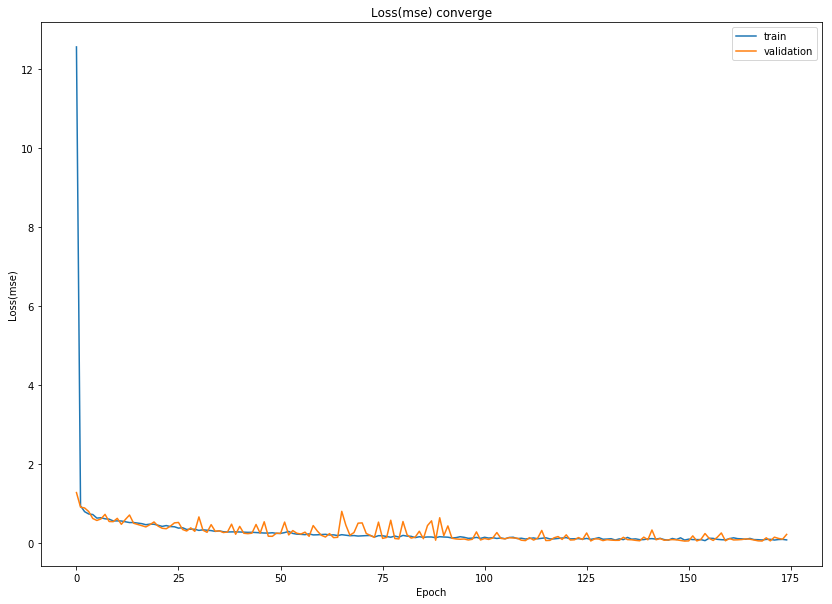

Wall time: 9min 3s


In [19]:
%time model_ATM, result_ATM = create_model(X_train_ATM, y_train_ATM)

,predicted,actual
0,0.941435,0.88
1,2.018028,1.93
2,8.173476,7.70
3,3.679376,3.45
4,0.530628,0.62
5,0.725181,0.59
6,1.494916,1.38
7,0.424854,0.53
8,2.928391,2.49
9,0.490169,0.44


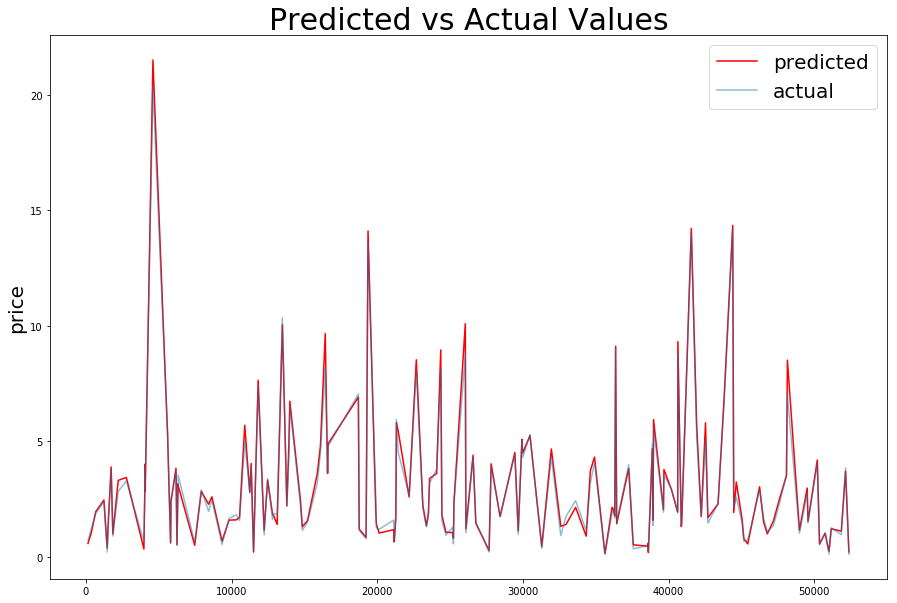

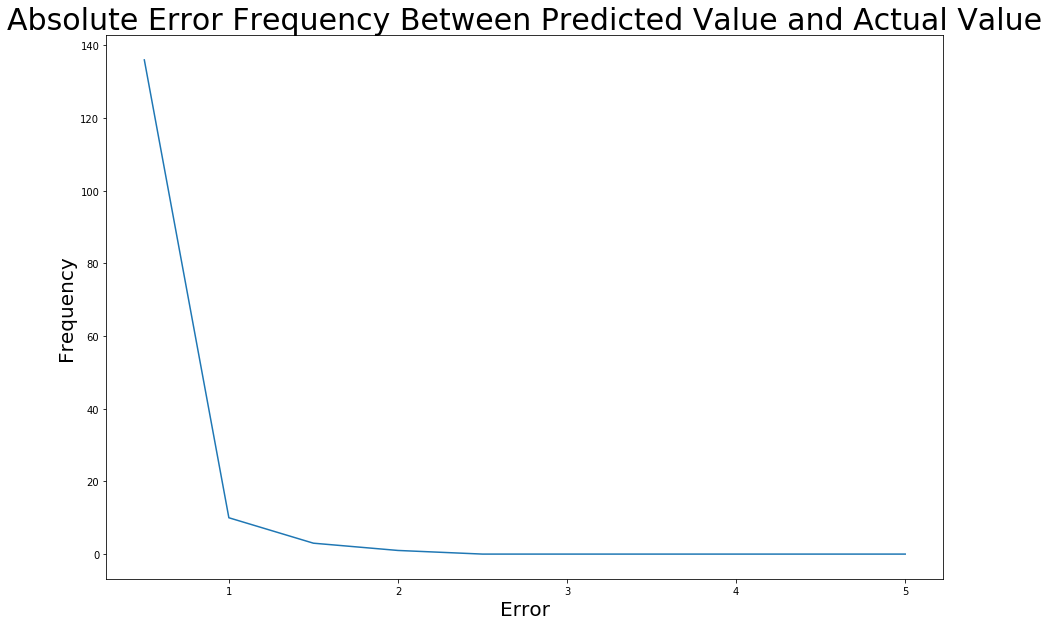

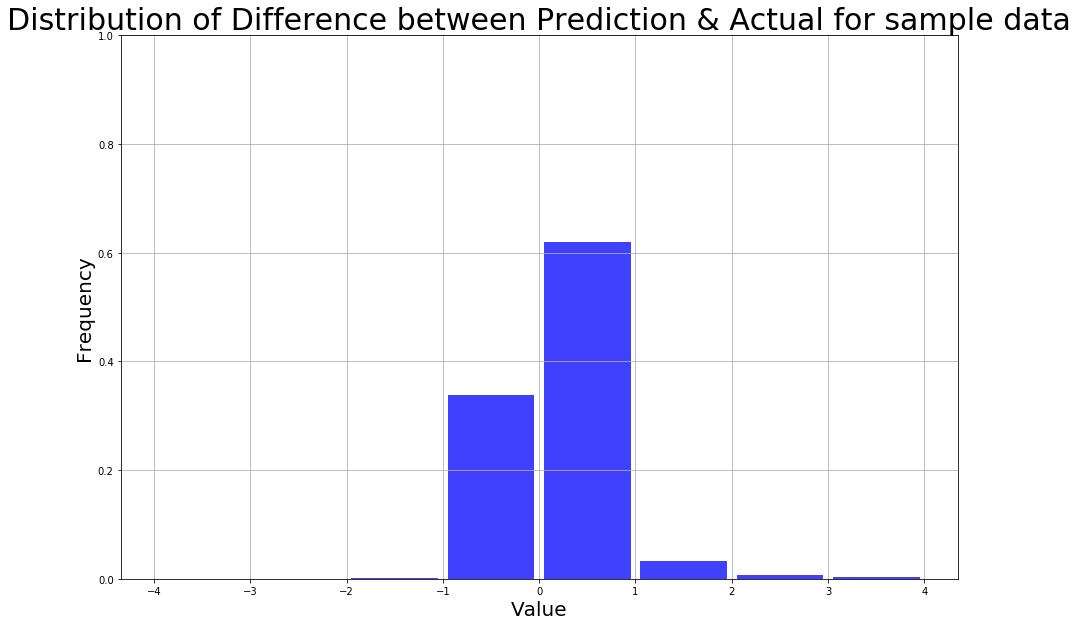



Mean absolute error (MAE): 0.253567
Mean squared error (MSE):  0.217567
R square (R^2):            0.983775


In [28]:
pred_ATM = pred(model_ATM, X_test_ATM, y_test_ATM)

In [21]:
model_ATM.save('model4_2_ATM_ori.h5')

## Build model with out-the-money option data

In [22]:
X_train_OTM, X_test_OTM, y_train_OTM, y_test_OTM = data(OTM_df)

Train on 540635 samples, validate on 60071 samples
Epoch 1/200
540635/540635 [==============================] - 10s 19us/step - loss: 4.9803 - mean_absolute_error: 0.8535 - val_loss: 0.5088 - val_mean_absolute_error: 0.4185
Epoch 2/200
540635/540635 [==============================] - 10s 18us/step - loss: 0.6449 - mean_absolute_error: 0.4864 - val_loss: 0.4647 - val_mean_absolute_error: 0.3955
Epoch 3/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.5075 - mean_absolute_error: 0.4223 - val_loss: 0.4645 - val_mean_absolute_error: 0.4033
Epoch 4/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.4515 - mean_absolute_error: 0.3968 - val_loss: 0.5341 - val_mean_absolute_error: 0.4143
Epoch 5/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.4178 - mean_absolute_error: 0.3814 - val_loss: 0.3753 - val_mean_absolute_error: 0.3358
Epoch 6/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.407

540635/540635 [==============================] - 9s 16us/step - loss: 0.1497 - mean_absolute_error: 0.2127 - val_loss: 0.1166 - val_mean_absolute_error: 0.1879
Epoch 49/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.1239 - mean_absolute_error: 0.1942 - val_loss: 0.1091 - val_mean_absolute_error: 0.1815
Epoch 50/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1195 - mean_absolute_error: 0.1915 - val_loss: 0.1207 - val_mean_absolute_error: 0.1975
Epoch 51/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1405 - mean_absolute_error: 0.2067 - val_loss: 0.1398 - val_mean_absolute_error: 0.2109
Epoch 52/200
540635/540635 [==============================] - 9s 18us/step - loss: 0.1416 - mean_absolute_error: 0.2056 - val_loss: 0.1125 - val_mean_absolute_error: 0.1791
Epoch 53/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.1436 - mean_absolute_error: 0.2061 - val_loss: 0.1475 - val_mea

540635/540635 [==============================] - 9s 16us/step - loss: 0.0918 - mean_absolute_error: 0.1680 - val_loss: 0.0869 - val_mean_absolute_error: 0.1661e_error: 0
Epoch 96/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.0866 - mean_absolute_error: 0.1637 - val_loss: 0.1344 - val_mean_absolute_error: 0.2020
Epoch 97/200
540635/540635 [==============================] - 9s 16us/step - loss: 0.1047 - mean_absolute_error: 0.1784 - val_loss: 0.0918 - val_mean_absolute_error: 0.1777
Epoch 98/200
540635/540635 [==============================] - 8s 16us/step - loss: 0.1002 - mean_absolute_error: 0.1754 - val_loss: 0.0725 - val_mean_absolute_error: 0.1489
Epoch 99/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0872 - mean_absolute_error: 0.1634 - val_loss: 0.0816 - val_mean_absolute_error: 0.1615
Epoch 100/200
540635/540635 [==============================] - 10s 18us/step - loss: 0.0903 - mean_absolute_error: 0.1659 - val_loss: 0.07

Epoch 142/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0795 - mean_absolute_error: 0.1559 - val_loss: 0.0667 - val_mean_absolute_error: 0.1467
Epoch 143/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0793 - mean_absolute_error: 0.1556 - val_loss: 0.1404 - val_mean_absolute_error: 0.2159
Epoch 144/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0956 - mean_absolute_error: 0.1699 - val_loss: 0.1055 - val_mean_absolute_error: 0.1841
Epoch 145/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0831 - mean_absolute_error: 0.1576 - val_loss: 0.0665 - val_mean_absolute_error: 0.1384
Epoch 146/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0805 - mean_absolute_error: 0.1567 - val_loss: 0.0990 - val_mean_absolute_error: 0.1934
Epoch 147/200
540635/540635 [==============================] - 9s 17us/step - loss: 0.0813 - mean_absolute_error: 0.1576 - val_los

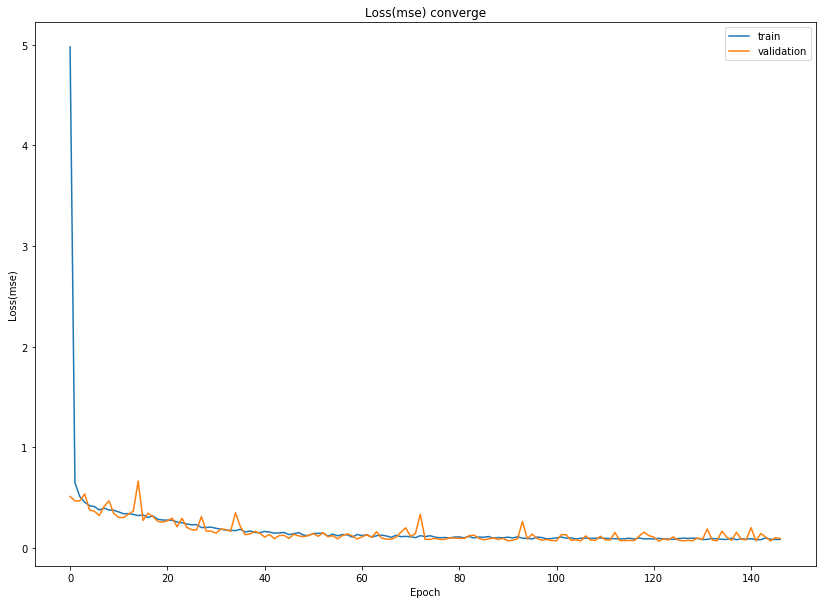

Wall time: 22min 33s


In [23]:
%time model_OTM, result_OTM = create_model(X_train_OTM, y_train_OTM)

,predicted,actual
0,0.303514,0.27
1,0.118278,0.12
2,0.141546,0.21
3,0.321283,0.50
4,0.067278,0.04
5,36.639896,37.45
6,0.370032,0.36
7,0.799442,0.84
8,0.396009,0.61
9,0.077385,0.07


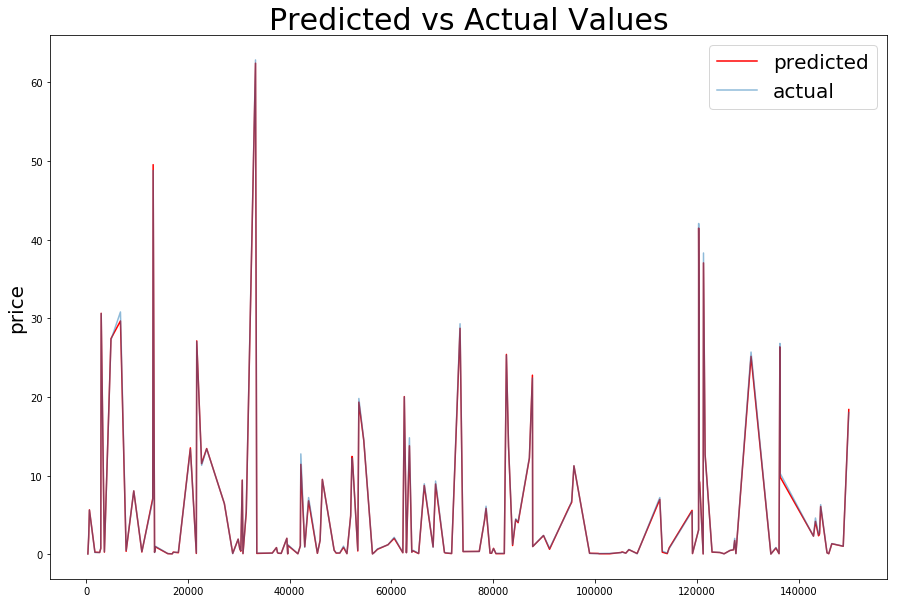

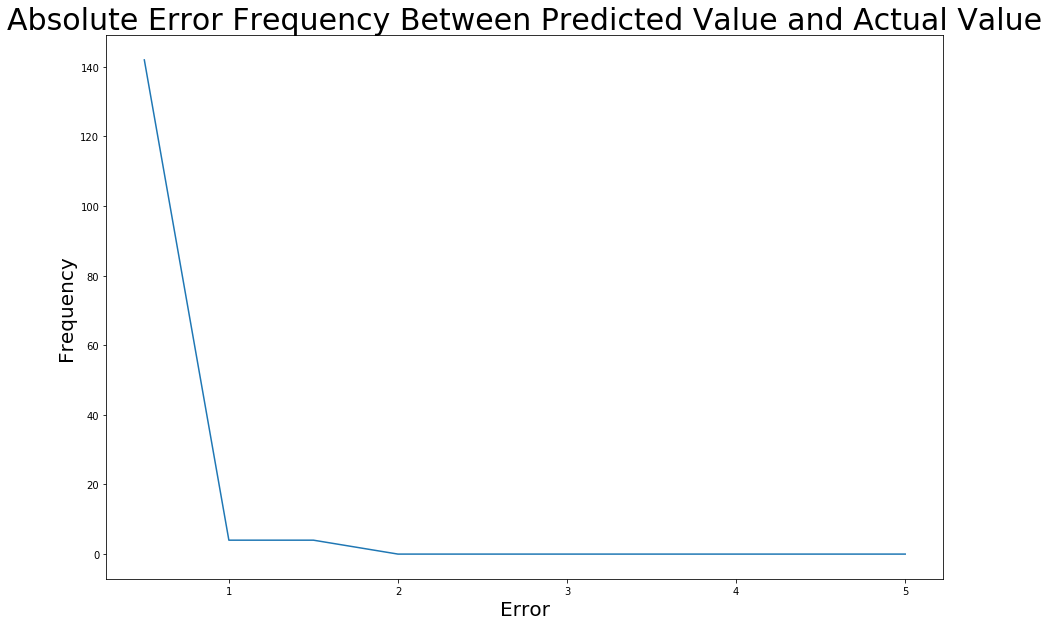

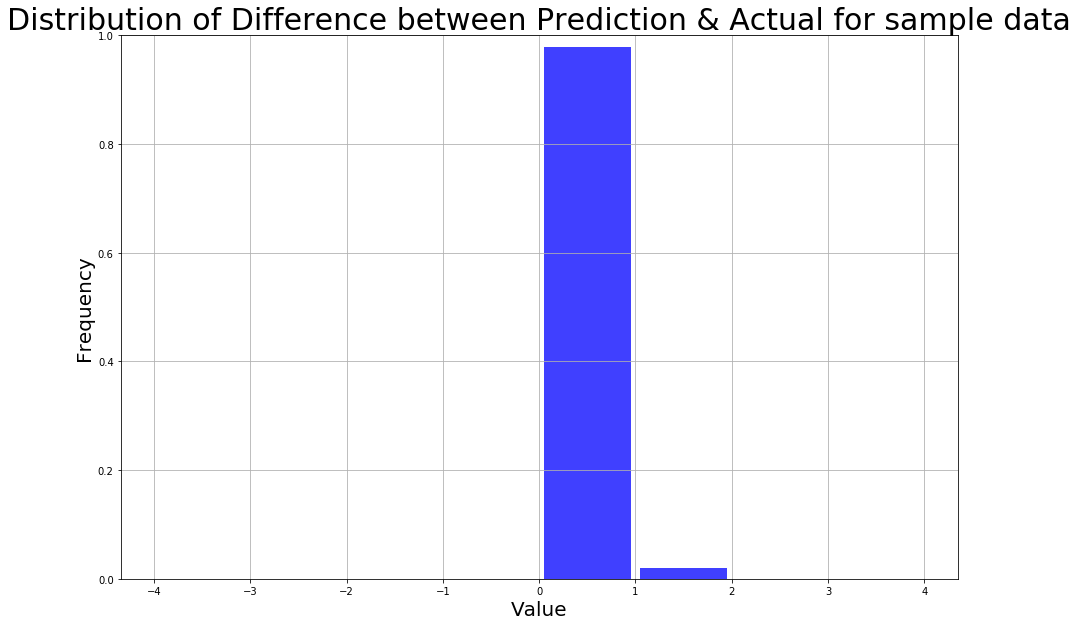



Mean absolute error (MAE): 0.159651
Mean squared error (MSE):  0.089074
R square (R^2):            0.999221


In [24]:
pred_OTM = pred(model_OTM, X_test_OTM, y_test_OTM)

In [25]:
model_OTM.save('model4_2_OTM_ori.h5')

## Build model with whole data

In [29]:
X_train, X_test, y_train, y_test = data(sample_df.sample(frac = 0.7))

In [30]:
print(X_train[:10])
print(y_train[:10])

         intrinsic  strike_price  underlying_price  maturity  impl_volatility  \
1331220      95.57         310.0            214.43        58         0.435198   
147574        0.41          40.0             40.41         9         0.205047   
94573        19.88          95.0             75.12       569         0.235753   
651536       21.18         147.0            168.18        23         0.231109   
1851          0.00          70.0             57.67       481         0.225279   
429359        0.00          85.0             86.22        30         0.182520   
757370        0.00         192.5            194.44        11         0.191607   
1170756       0.00          46.5             40.49        30         0.222850   
633317        0.00         140.0            167.64       358         0.252798   
1206099       0.04          41.5             41.54        25         0.118076   

         cp_flag_P  interest_rate  
1331220          1         0.0001  
147574           0         0.0005  


Train on 856917 samples, validate on 95214 samples
Epoch 1/200
856917/856917 [==============================] - 16s 18us/step - loss: 5.1387 - mean_absolute_error: 0.9550 - val_loss: 0.6425 - val_mean_absolute_error: 0.4767
Epoch 2/200
856917/856917 [==============================] - 15s 18us/step - loss: 0.7106 - mean_absolute_error: 0.5190 - val_loss: 0.5190 - val_mean_absolute_error: 0.4198
Epoch 3/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.5633 - mean_absolute_error: 0.4528 - val_loss: 0.4222 - val_mean_absolute_error: 0.3731
Epoch 4/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.4626 - mean_absolute_error: 0.4051 - val_loss: 0.4763 - val_mean_absolute_error: 0.4350
Epoch 5/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.4384 - mean_absolute_error: 0.3939 - val_loss: 0.6080 - val_mean_absolute_error: 0.4487
Epoch 6/200
856917/856917 [==============================] - 15s 17us/step - loss: 0

Epoch 48/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1280 - mean_absolute_error: 0.1969 - val_loss: 0.0940 - val_mean_absolute_error: 0.1655
Epoch 49/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.1181 - mean_absolute_error: 0.1897 - val_loss: 0.1341 - val_mean_absolute_error: 0.1951
Epoch 50/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1267 - mean_absolute_error: 0.1945 - val_loss: 0.1450 - val_mean_absolute_error: 0.2350
Epoch 51/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1289 - mean_absolute_error: 0.1981 - val_loss: 0.1541 - val_mean_absolute_error: 0.2148
Epoch 52/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1247 - mean_absolute_error: 0.1951 - val_loss: 0.0907 - val_mean_absolute_error: 0.1647
Epoch 53/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.1191 - mean_absolute_error: 0.1898 - val_los

856917/856917 [==============================] - 15s 17us/step - loss: 0.0996 - mean_absolute_error: 0.1736 - val_loss: 0.0915 - val_mean_absolute_error: 0.1616
Epoch 96/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0934 - mean_absolute_error: 0.1678 - val_loss: 0.0727 - val_mean_absolute_error: 0.1436
Epoch 97/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.0981 - mean_absolute_error: 0.1719 - val_loss: 0.0793 - val_mean_absolute_error: 0.1527
Epoch 98/200
856917/856917 [==============================] - 14s 17us/step - loss: 0.0910 - mean_absolute_error: 0.1658 - val_loss: 0.1553 - val_mean_absolute_error: 0.2405
Epoch 99/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.1001 - mean_absolute_error: 0.1742 - val_loss: 0.0799 - val_mean_absolute_error: 0.1509
Epoch 100/200
856917/856917 [==============================] - 15s 17us/step - loss: 0.0877 - mean_absolute_error: 0.1627 - val_loss: 0.0873 - 

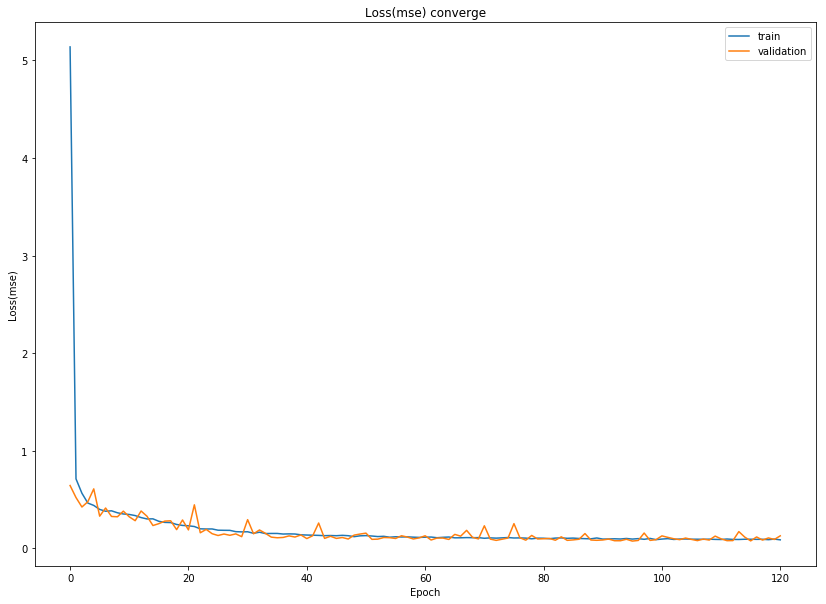

Wall time: 29min 55s


In [31]:
%time model, result = create_model(X_train, y_train)

,predicted,actual
0,62.210327,62.10
1,0.082203,0.19
2,1.858700,1.71
3,5.094873,5.20
4,1.050057,1.05
5,3.956273,3.80
6,1.183744,1.22
7,11.509665,11.10
8,0.341762,0.47
9,0.934385,1.05


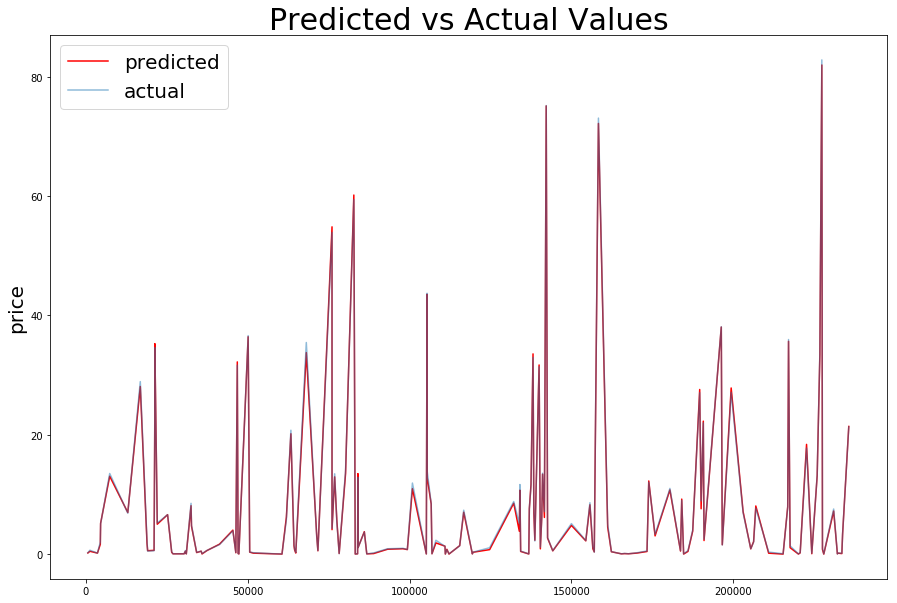

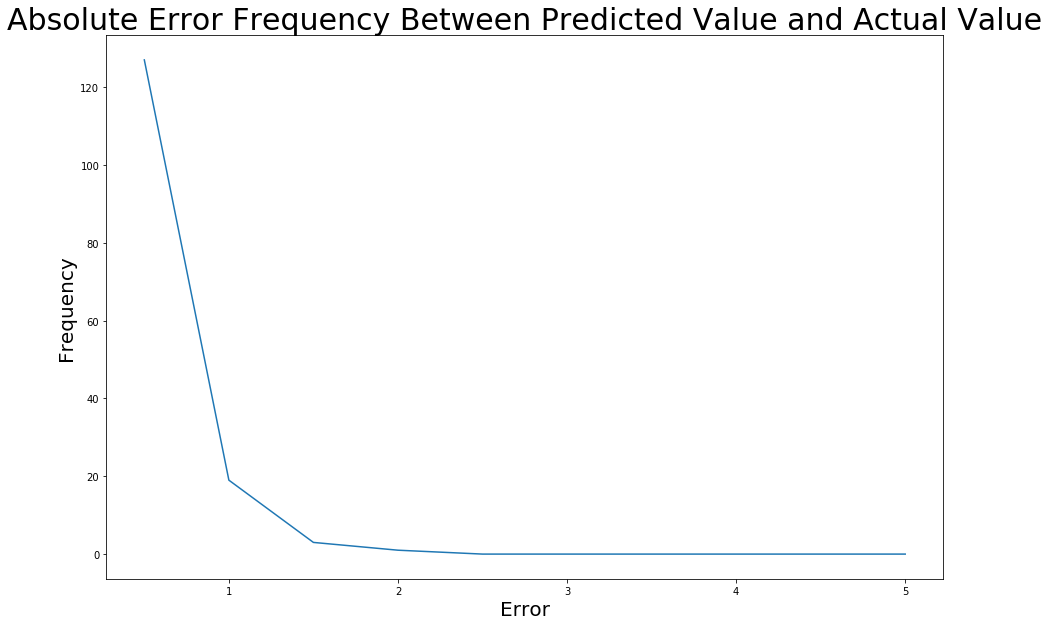

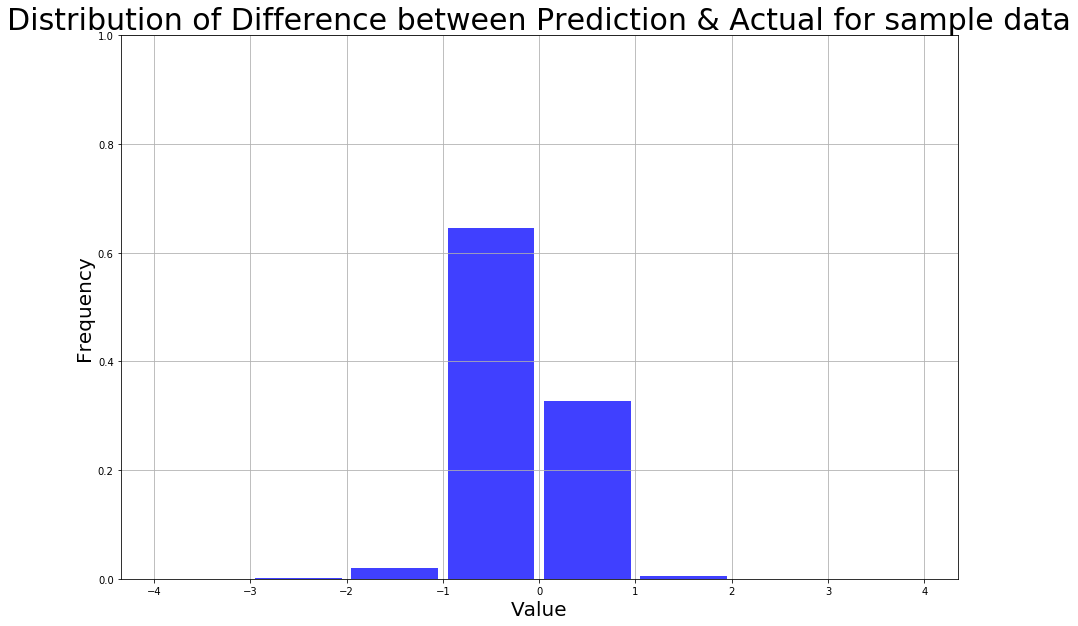



Mean absolute error (MAE): 0.202119
Mean squared error (MSE):  0.126826
R square (R^2):            0.999138


In [34]:
pred_whole = pred(model, X_test, y_test)

In [35]:
model.save('model4_2_whole_ori.h5')

# Prediction

We use the three models we built above to do option price prediction. In the above, the train and test dataset were generated from the same dataset, even though they were splited randomly, the data structures were very similar. In this section, we want to apply the models to out of sample data which is in different time range from the data used to train the model to check our models' robustness. 

In [36]:
def load_prediction_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df['moneyness'] = df.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'moneyness', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    ITM_df = df[df['moneyness'] <= 0.97]
    ATM_df = df[df['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = df[df['moneyness'] >= 1.03]
    
    return df, ITM_df, ATM_df, OTM_df

In [37]:
p_df, p_df_ITM, p_df_ATM, p_df_OTM = load_prediction_data()

In [38]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     sc_X.fit(X)
#     X_scale = sc_X.transform(X)

#     sc_y = StandardScaler()
#     y = y.reshape(-1,1)
#     sc_y.fit(y)
#     y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X)
    
    pred = pred.flatten()
#     y_scale = y_scale.flatten()
    y = y.flatten()
#     y_pred = sc_y.inverse_transform(pred)
    
    d = {'predict': pred, 'actual':y}
    datanew = pd.DataFrame(data = d)
    display(datanew.head(10))
      
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
     #Line graph for sample data
    plt.figure(1, figsize = (15,10))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted', color = 'r')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual', alpha = 0.5)
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.show()
    #Absolute error
    l,binEdges=np.histogram(np.abs(sample_data['predict']-sample_data['actual']),bins= [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
    plt.figure(2, figsize = (15,10))
    plt.plot(binEdges[1:],l,'-')
    plt.xlabel('Error', fontsize = 20)
    plt.ylabel('Frequency', fontsize = 20)
    plt.title('Absolute Error Frequency Between Predicted Value and Actual Value', fontsize = 30)
    plt.show()
     
    #Histogram of diff for all data
    plt.figure(3,figsize = (15,10))
    n, bins, patches = plt.hist((datanew['predict']-datanew['actual']), 8, range = (-4,4),density=True, color='blue', alpha=0.75,rwidth = 0.9)
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
#     plt.xticks(fontsize=40)
#     plt.yticks(fontsize=40)
    plt.title('Distribution of Difference between Prediction & Actual for sample data', fontsize=30) 
    

    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, pred))
    #print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, y_pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, pred))

## Predict in-the-money option data

,predict,actual
0,1.100828,0.13
1,0.933023,0.13
2,0.127779,0.06
3,0.106415,0.04
4,0.091944,0.03
5,0.074326,0.03
6,0.074197,0.03
7,0.059184,0.02
8,0.116364,0.06
9,0.109160,0.05


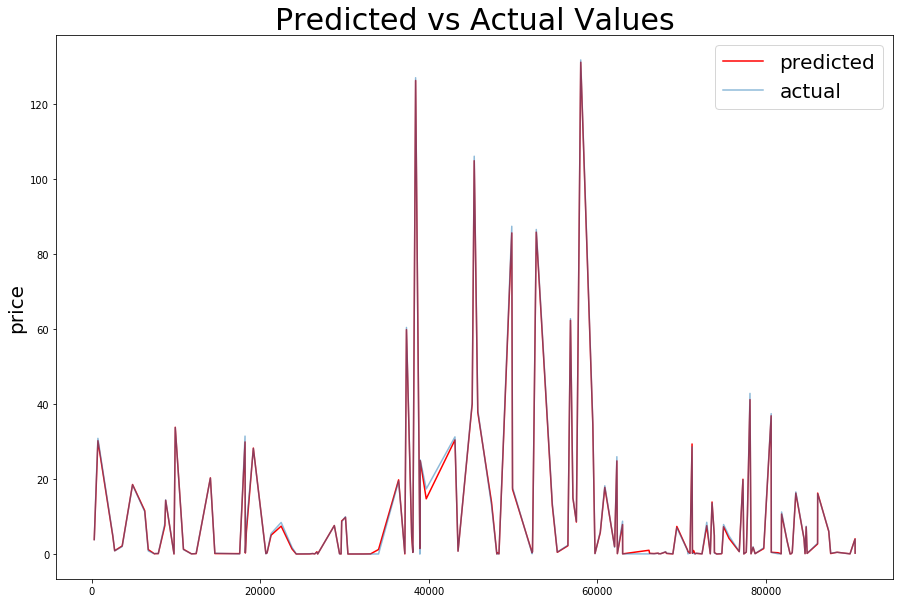

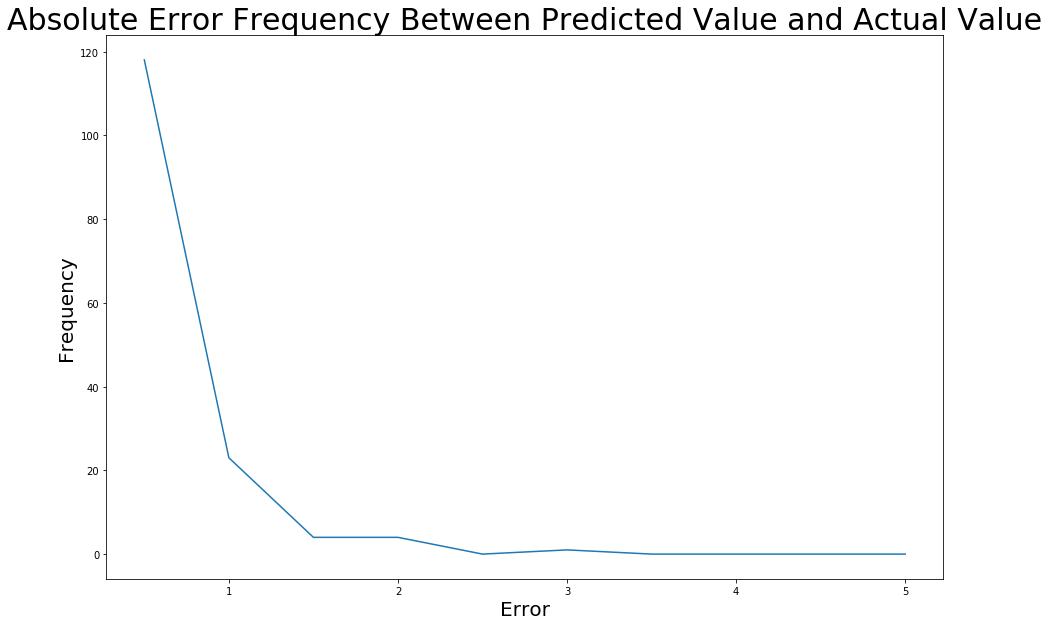

Mean absolute error (MAE):      0.310443
Mean squared error (MSE):       0.358518
R square (R^2):                 0.998899


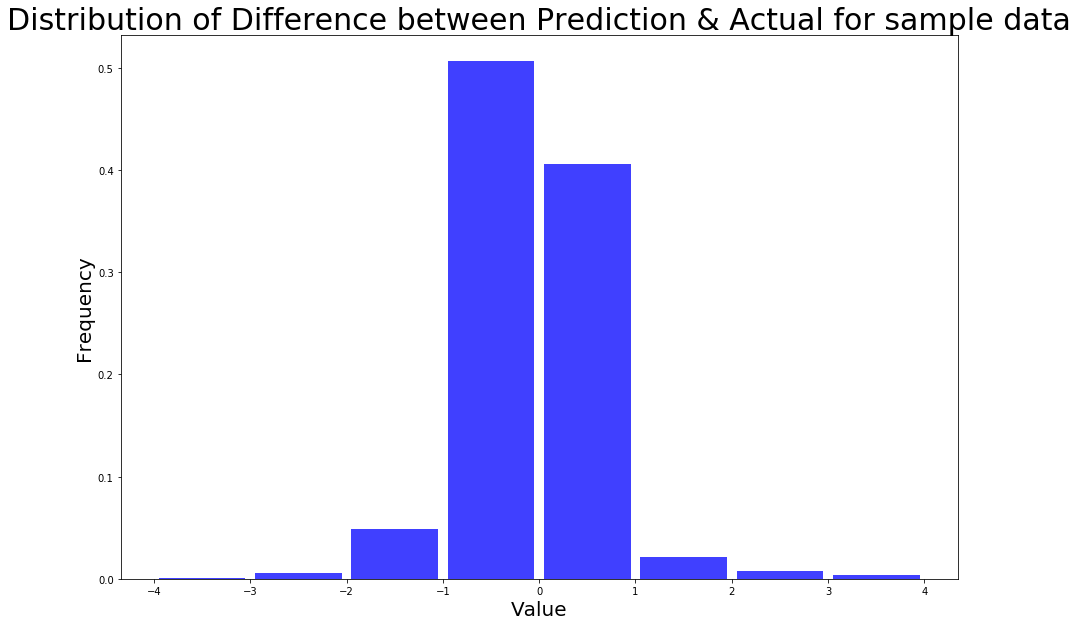

In [39]:
model_pred(p_df_ITM, model_ITM, 'impl_volatility')

,predict,actual
0,0.485994,0.13
1,0.497434,0.13
2,0.096235,0.06
3,0.066491,0.04
4,0.049361,0.03
5,0.042082,0.03
6,0.036204,0.03
7,0.044660,0.02
8,0.033180,0.06
9,0.008244,0.05


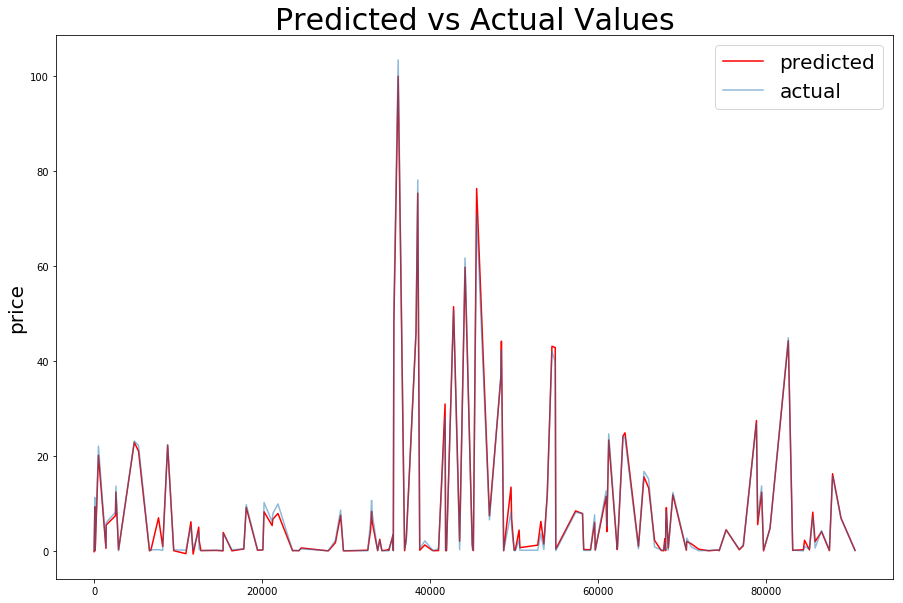

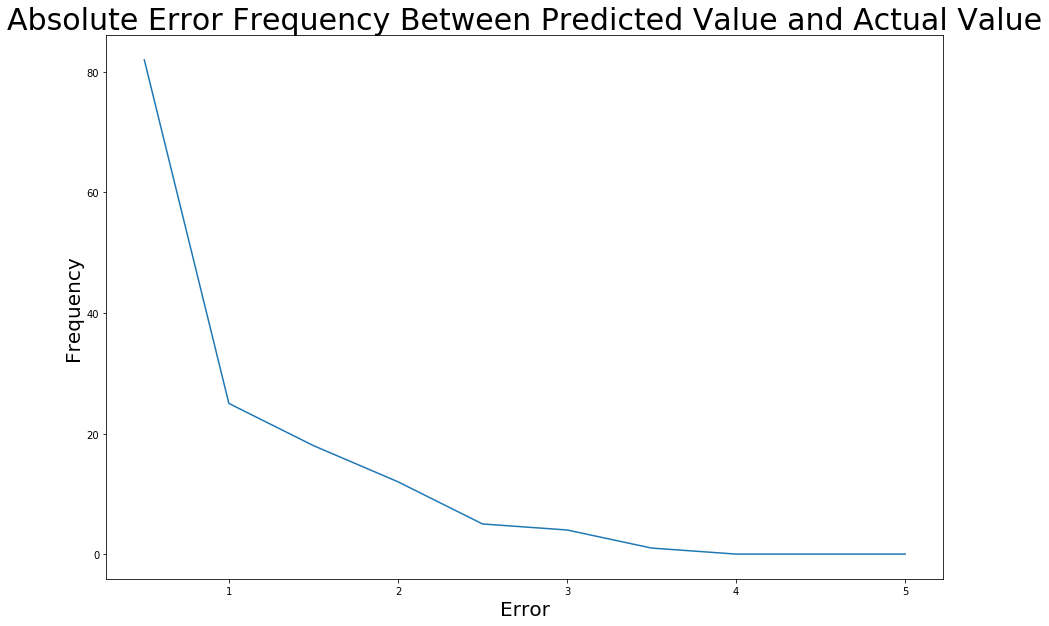

Mean absolute error (MAE):      0.749654
Mean squared error (MSE):       1.721139
R square (R^2):                 0.994715


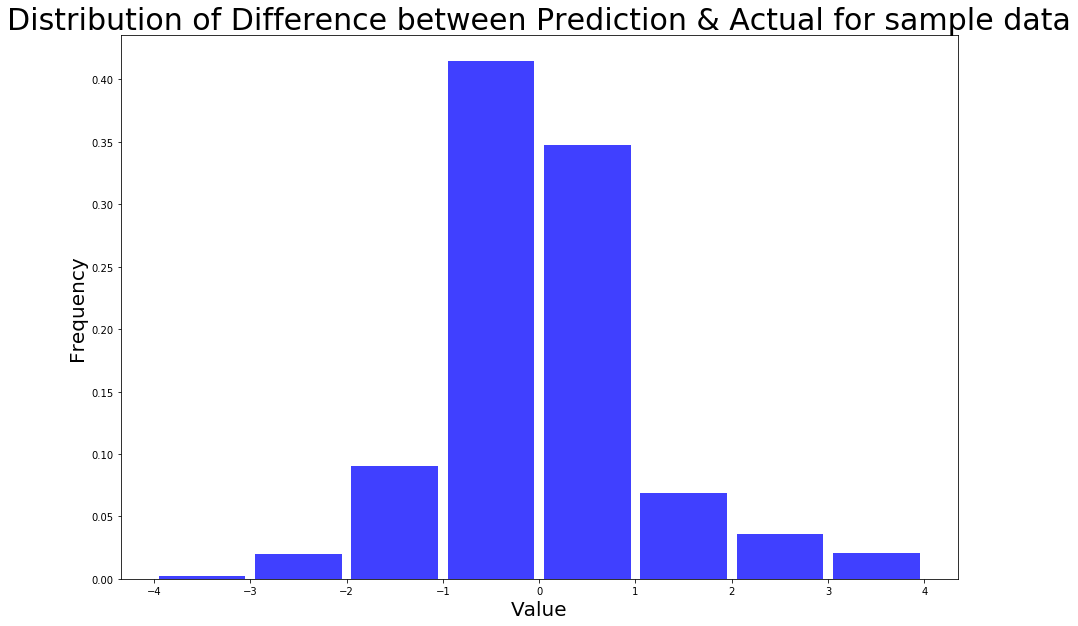

In [40]:
model_pred(p_df_ITM, model_ITM, 'realized_vol')

## Predict at-the-money option data

,predict,actual
0,1.811497,1.70
1,1.440793,1.31
2,1.112364,0.95
3,1.004259,0.66
4,0.929658,0.44
5,0.706372,0.28
6,0.503791,0.17
7,0.352486,0.10
8,0.247171,0.34
9,0.339092,0.48


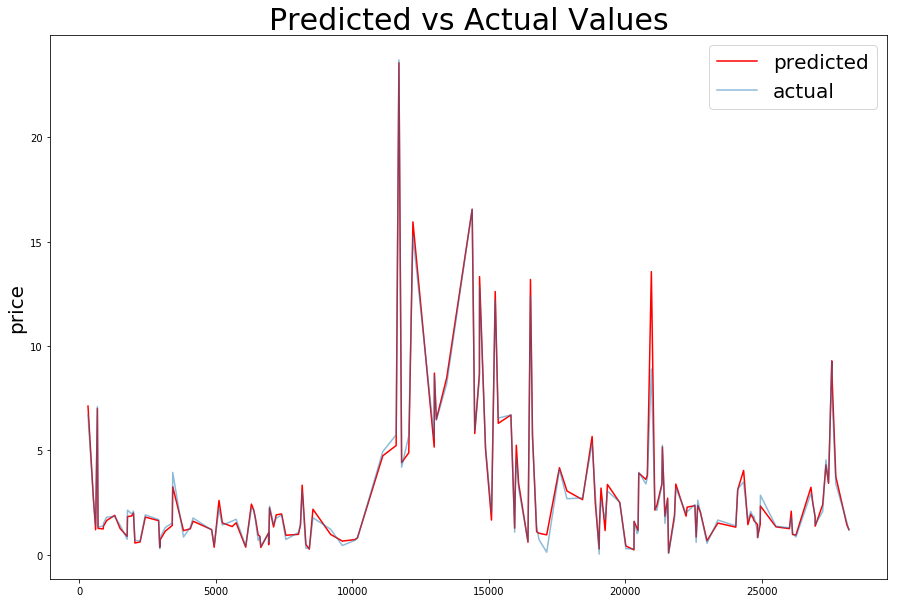

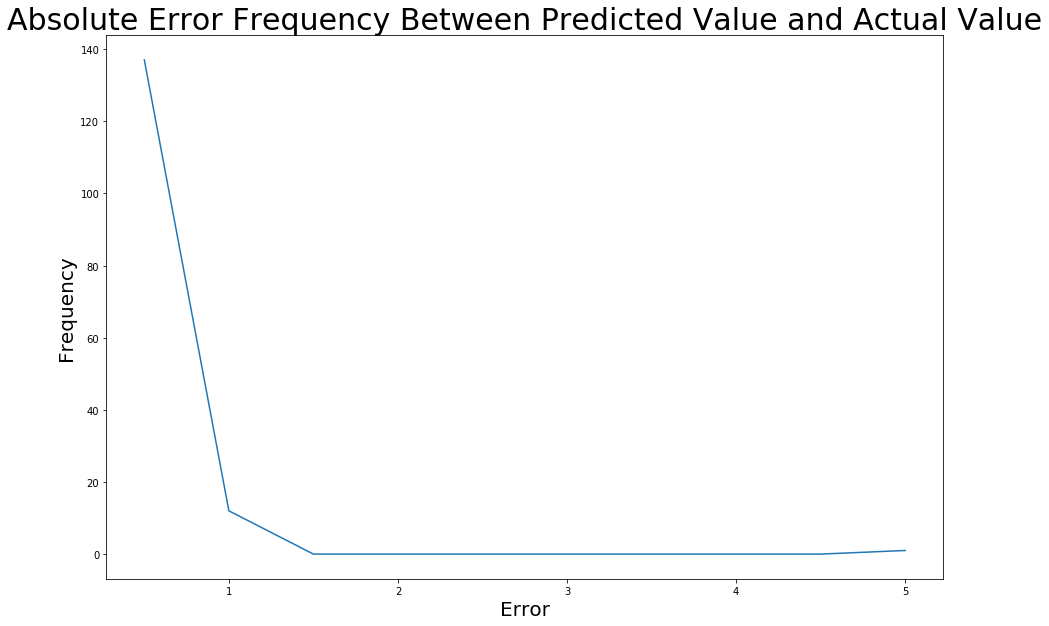

Mean absolute error (MAE):      0.245642
Mean squared error (MSE):       0.206323
R square (R^2):                 0.981816


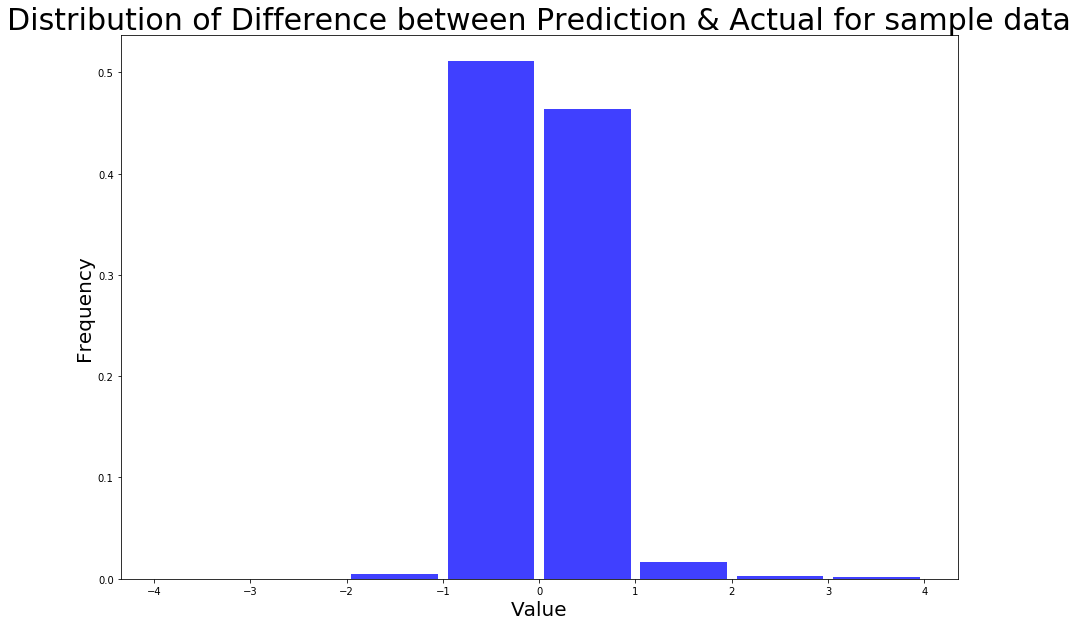

In [41]:
model_pred(p_df_ATM, model_ATM, 'impl_volatility')

,predict,actual
0,1.772007,1.70
1,1.345128,1.31
2,1.007023,0.95
3,0.881269,0.66
4,0.777638,0.44
5,0.574918,0.28
6,0.401619,0.17
7,0.242139,0.10
8,0.112745,0.34
9,0.189737,0.48


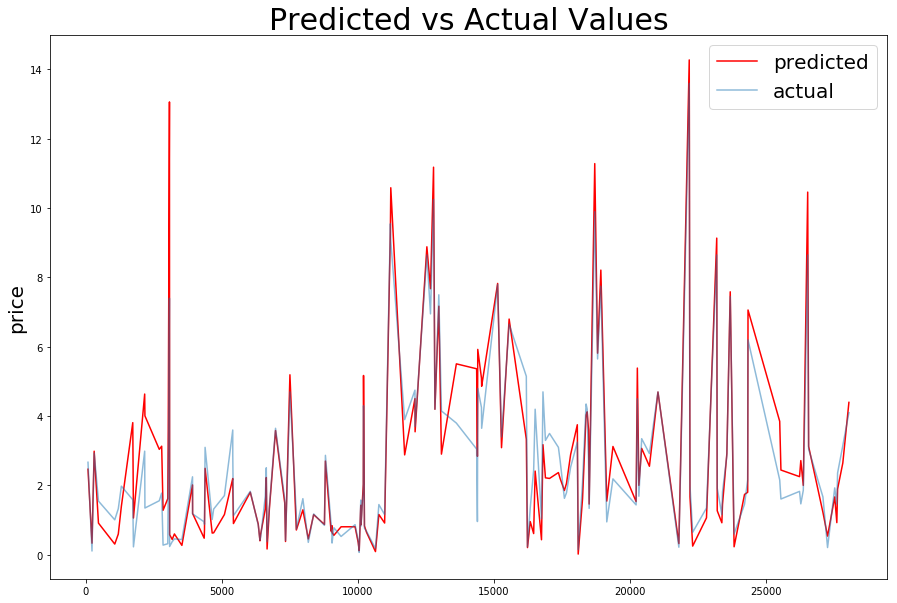

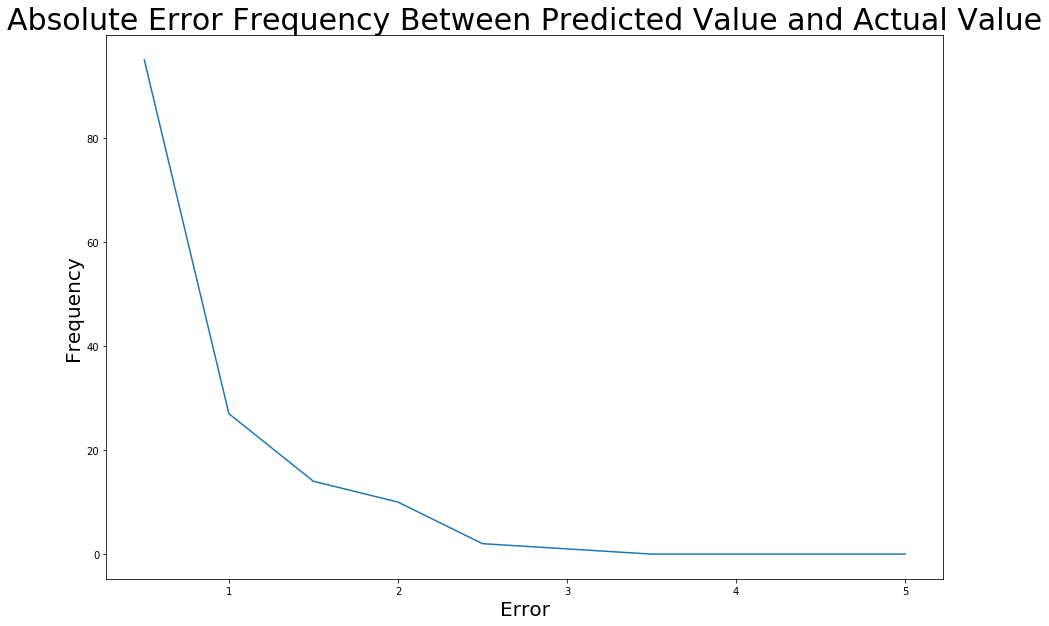

Mean absolute error (MAE):      0.602053
Mean squared error (MSE):       0.855012
R square (R^2):                 0.924643


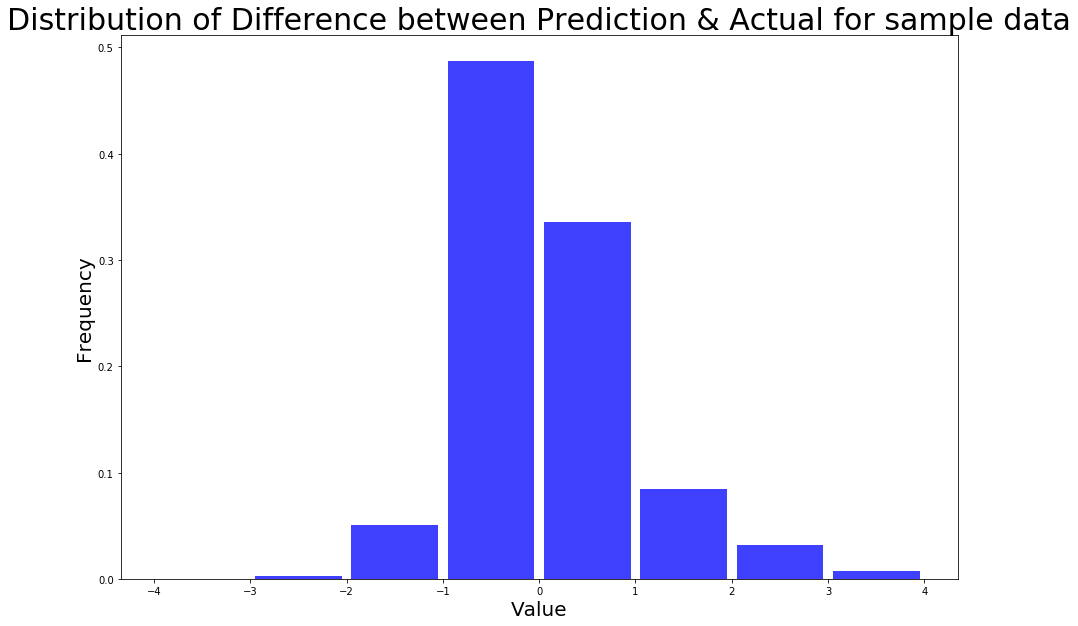

In [42]:
model_pred(p_df_ATM, model_ATM, 'realized_vol')

## Predict out-the-money option data

,predict,actual
0,0.275024,0.14
1,0.239347,0.13
2,0.189727,0.12
3,0.134713,0.06
4,0.036073,0.02
5,0.071582,0.04
6,0.088002,0.05
7,0.112200,0.06
8,0.126546,0.08
9,0.145875,0.10


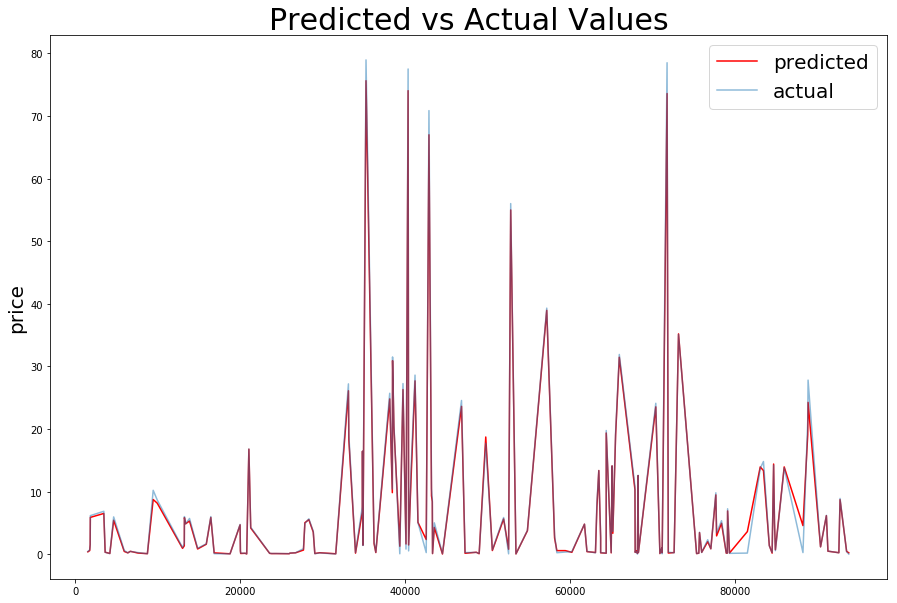

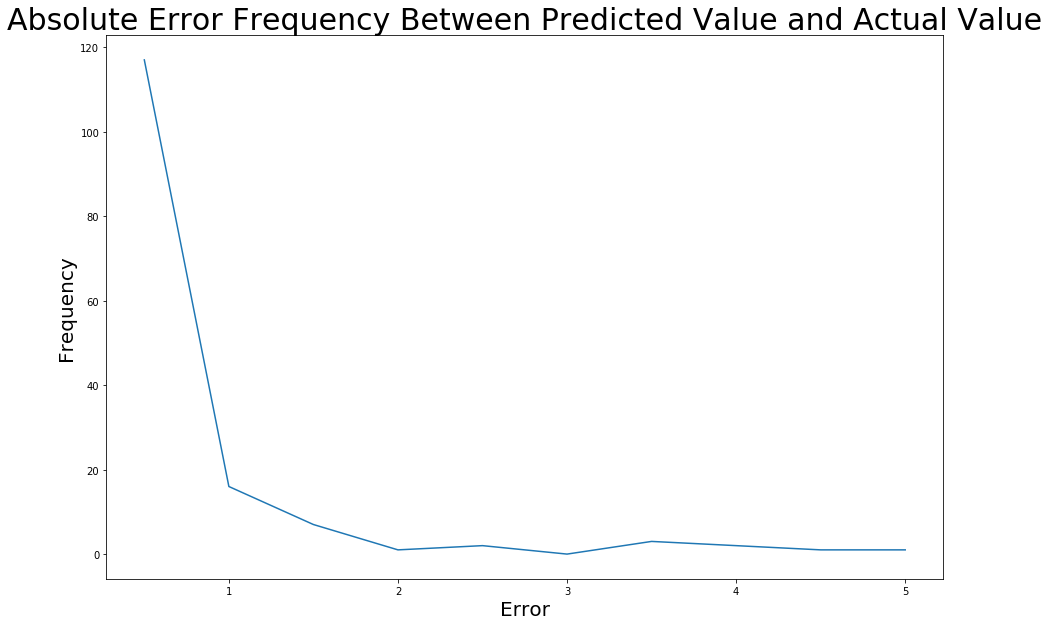

Mean absolute error (MAE):      0.378163
Mean squared error (MSE):       0.543968
R square (R^2):                 0.996920


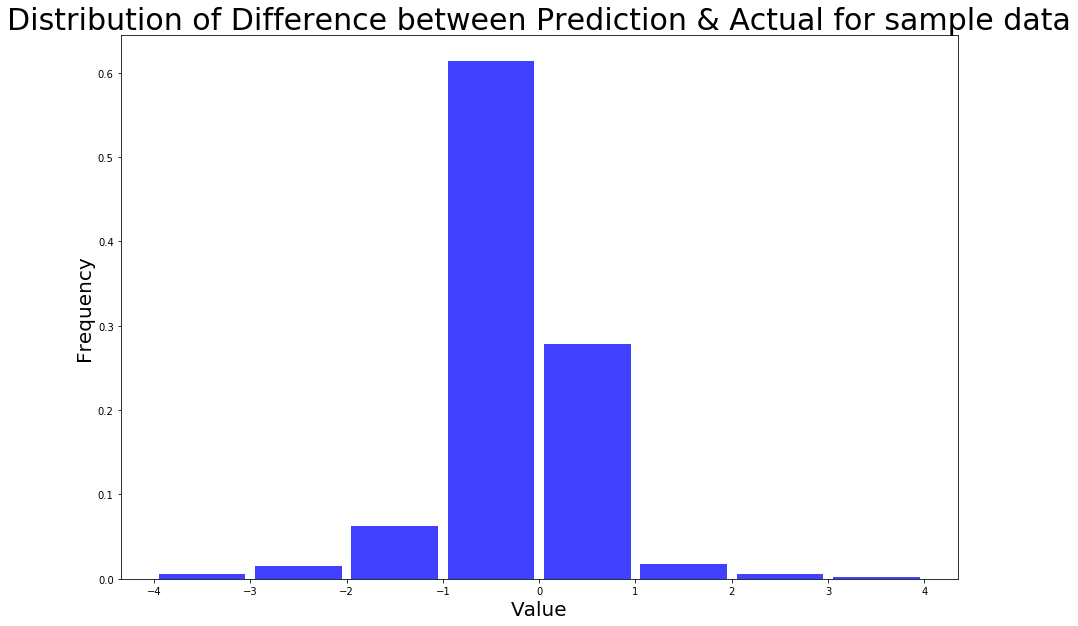

In [43]:
model_pred(p_df_OTM, model_OTM, 'impl_volatility')

,predict,actual
0,0.447922,0.14
1,0.131315,0.13
2,0.031535,0.12
3,0.047656,0.06
4,0.050720,0.02
5,0.035479,0.04
6,0.032185,0.05
7,0.046176,0.06
8,0.058223,0.08
9,0.065598,0.10


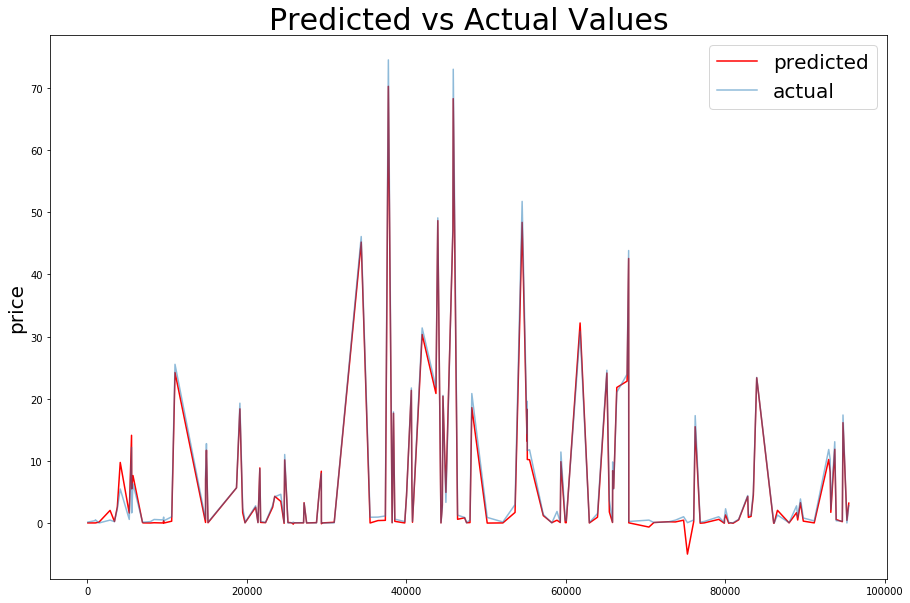

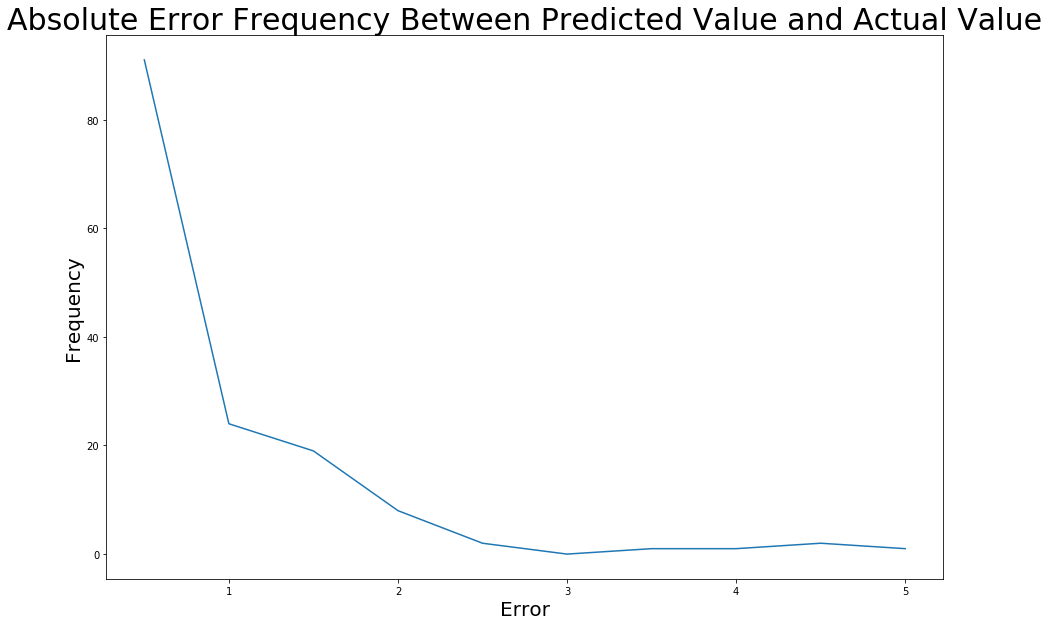

Mean absolute error (MAE):      0.691645
Mean squared error (MSE):       1.283768
R square (R^2):                 0.992730


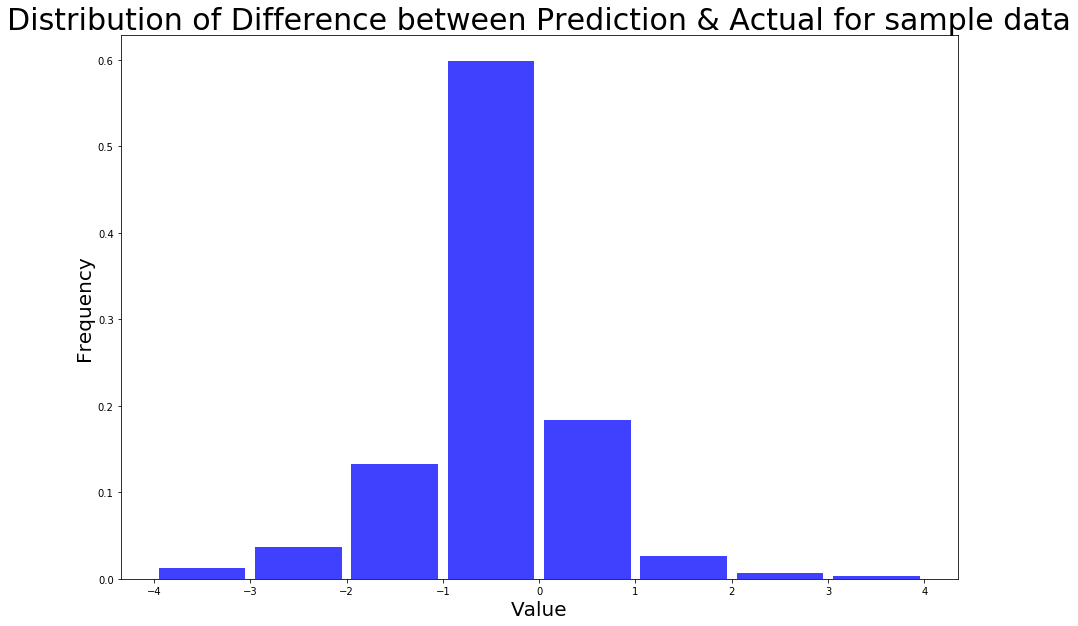

In [44]:
model_pred(p_df_OTM, model_OTM, 'realized_vol')

## Predict whole option data

,predict,actual
0,1.620600,0.13
1,2.193558,0.13
2,1.871741,1.70
3,1.445405,1.31
4,1.104222,0.95
5,0.748059,0.66
6,0.550487,0.44
7,0.377743,0.28
8,0.268768,0.17
9,0.214202,0.10


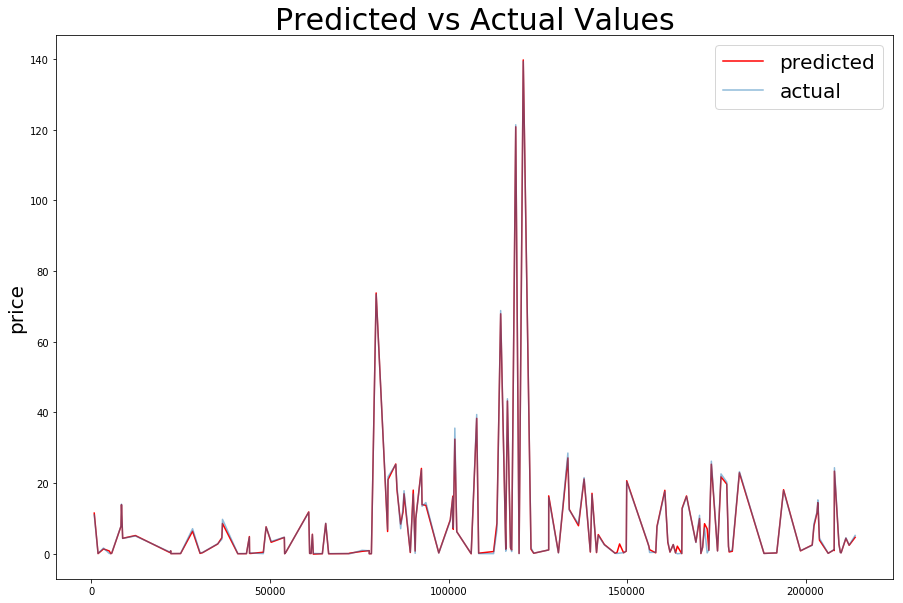

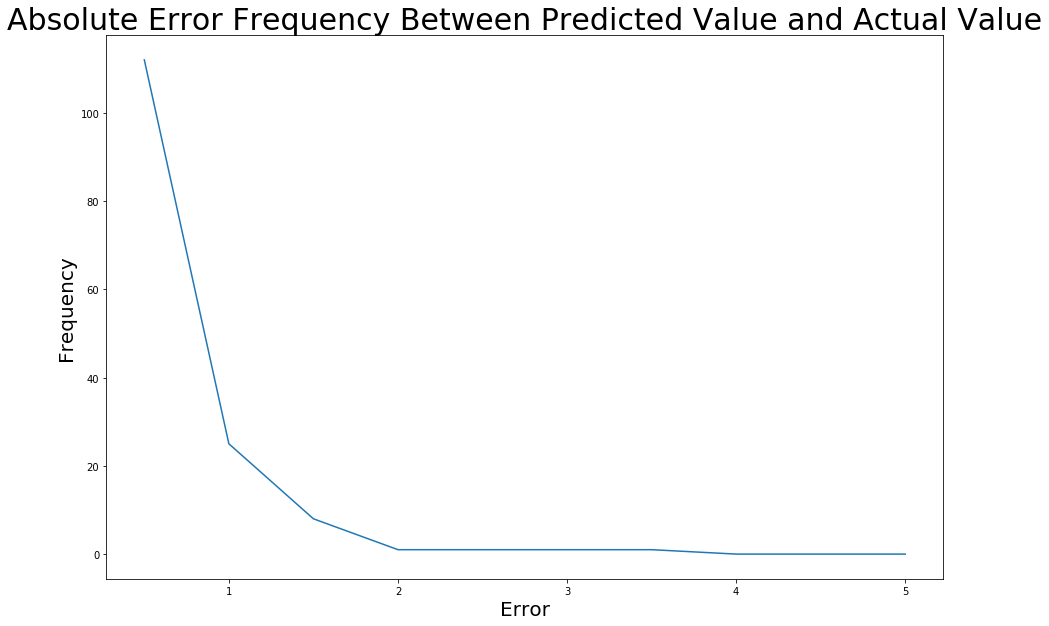

Mean absolute error (MAE):      0.352859
Mean squared error (MSE):       0.517466
R square (R^2):                 0.997659


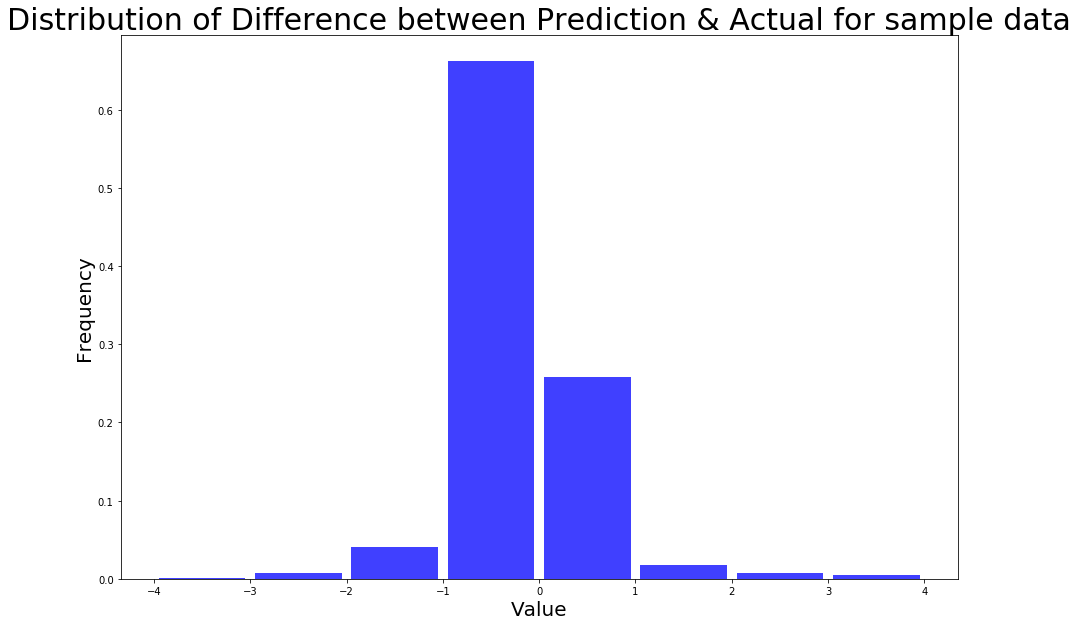

In [45]:
model_pred(p_df, model, 'impl_volatility')

,predict,actual
0,0.140051,0.13
1,0.080348,0.13
2,1.805983,1.70
3,1.365455,1.31
4,1.031409,0.95
5,0.548012,0.66
6,0.411436,0.44
7,0.298044,0.28
8,0.212221,0.17
9,0.150597,0.10


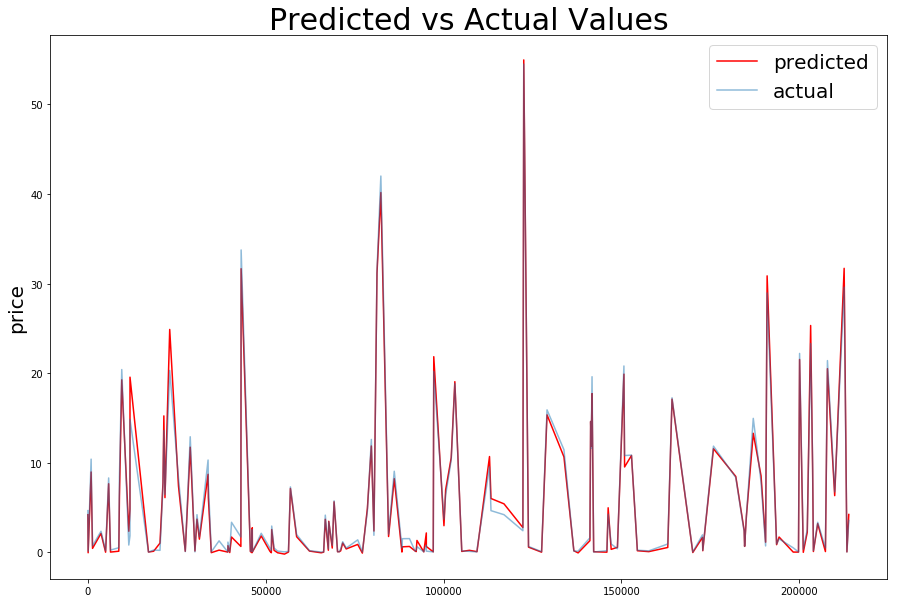

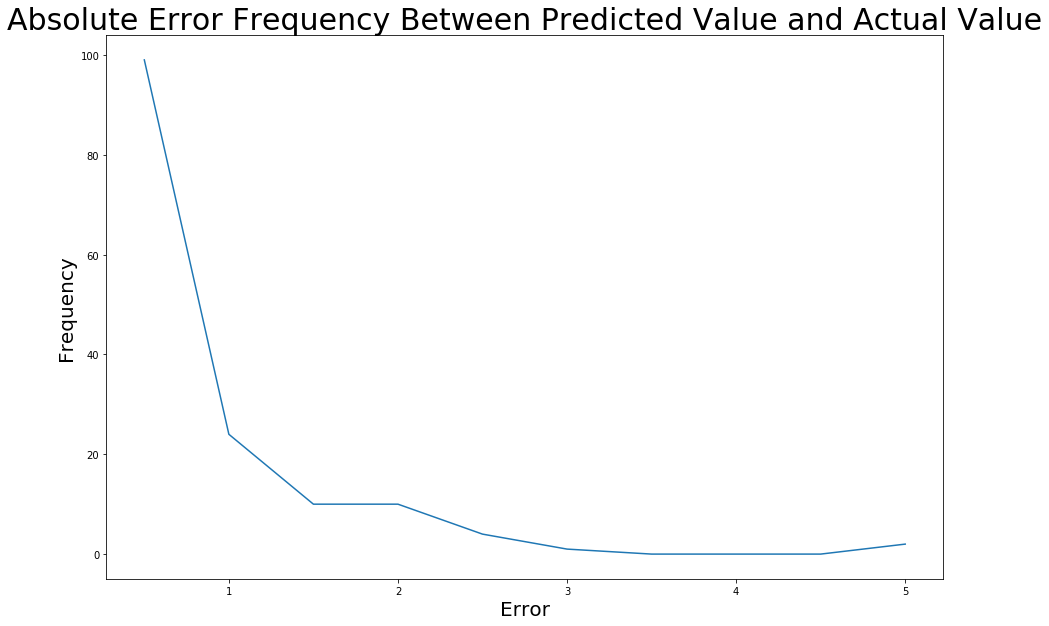

Mean absolute error (MAE):      0.584836
Mean squared error (MSE):       0.871510
R square (R^2):                 0.996057


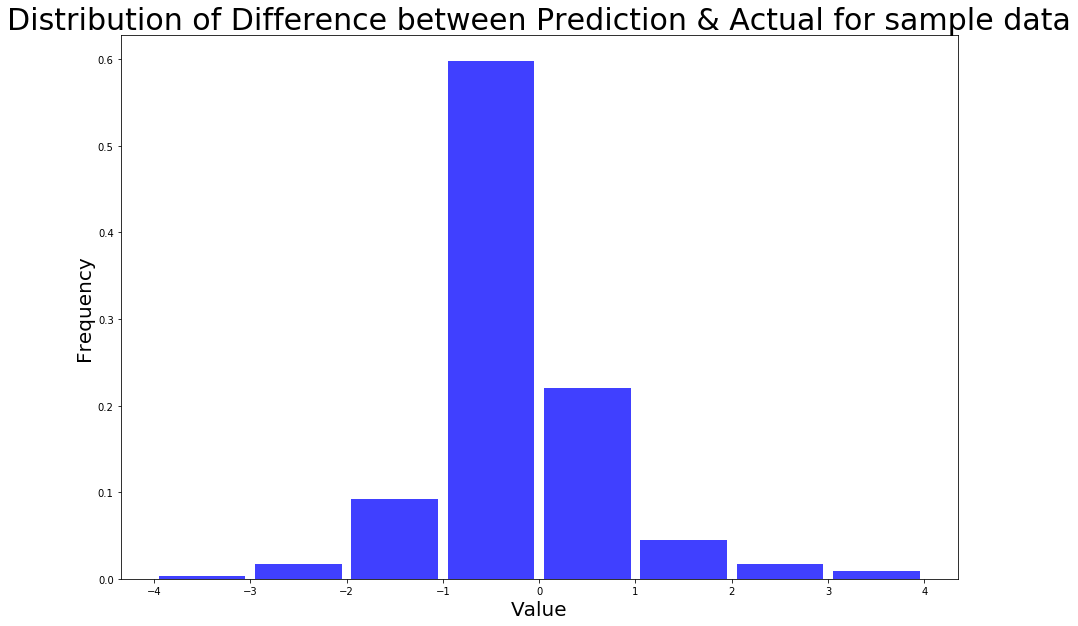

In [46]:
model_pred(p_df, model, 'realized_vol')

# Predict AAPL data(out of sample data)

In [47]:
def load_AAPL():
    AAPL = pd.read_csv('Options2016AAPL_withReaVo.csv')
    AAPL = AAPL.dropna()
    AAPL.rename(columns = {'Strike Price':'strike_price', 'Lowest  Closing Ask Across All Exchanges':'best_offer', 
                           'Underlying Price':'underlying_price', 'C=Call, P=Put_C':'cp_flag_C', 'C=Call, P=Put_P':'cp_flag_P',
                           'volatility':'realized_vol'}, inplace = True);
    AAPL['intrinsic'] = AAPL.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], 
                                                         row['cp_flag_P']), axis = 1)
    AAPL['moneyness'] = AAPL.apply(lambda row: moneyness(row['underlying_price'], row['strike_price']), axis = 1)
    
    ITM_df = AAPL[AAPL['moneyness'] <= 0.97]
    ATM_df = AAPL[AAPL['moneyness'].between(0.97, 1.03, inclusive = False)]
    OTM_df = AAPL[AAPL['moneyness'] >= 1.03]
    
    return AAPL, ITM_df, ATM_df, OTM_df

In [48]:
AAPL, AAPL_ITM, AAPL_ATM, AAPL_OTM = load_AAPL()

,predict,actual
0,0.138453,0.18
1,0.071900,0.10
2,0.056787,0.06
3,0.114746,0.04
4,0.202204,0.03
5,0.220802,0.03
6,0.218781,0.02
7,0.236390,0.02
8,0.262088,0.02
9,0.273260,0.02


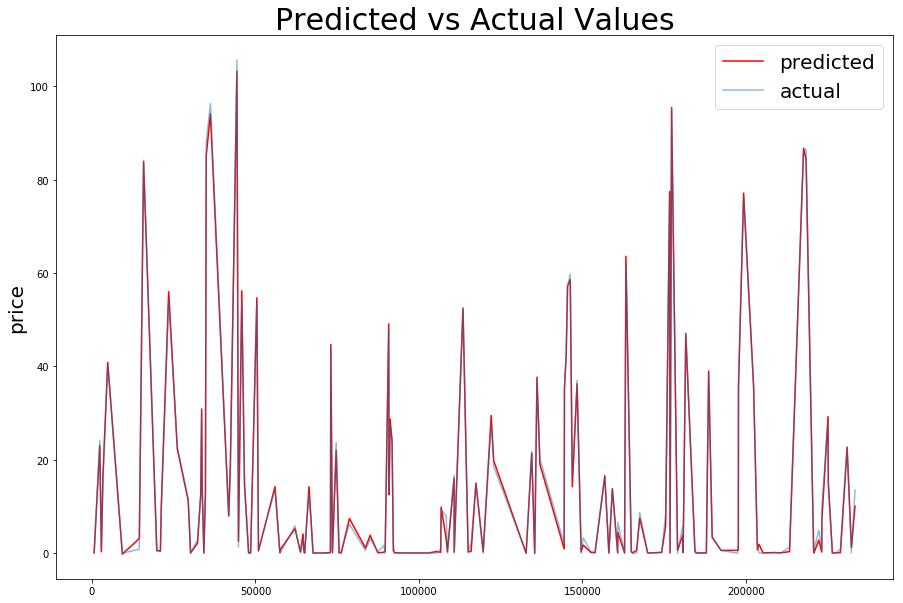

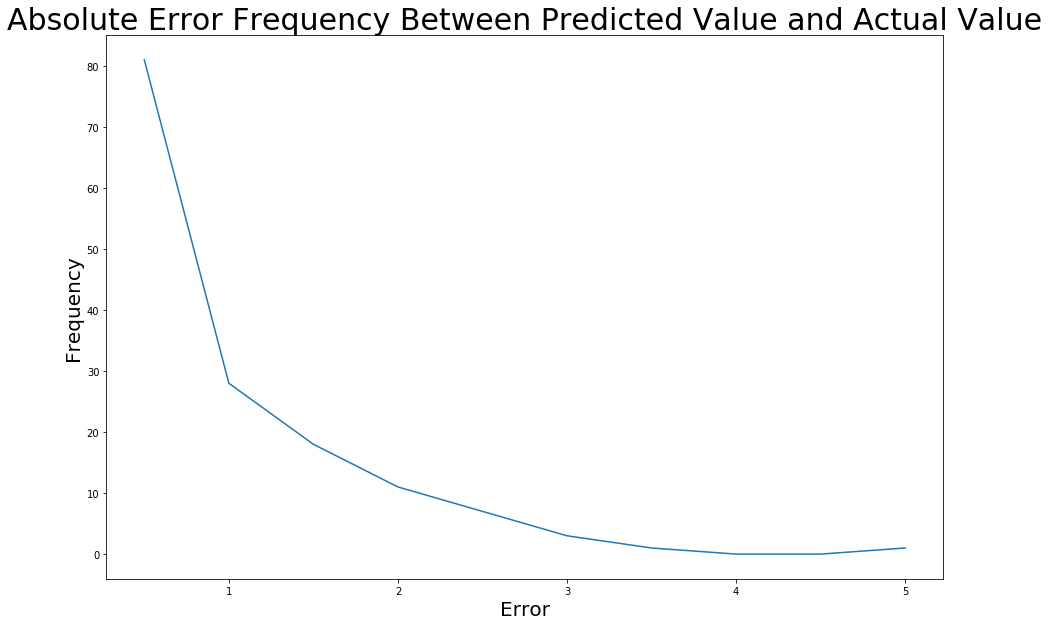

Mean absolute error (MAE):      0.670332
Mean squared error (MSE):       1.145669
R square (R^2):                 0.998371


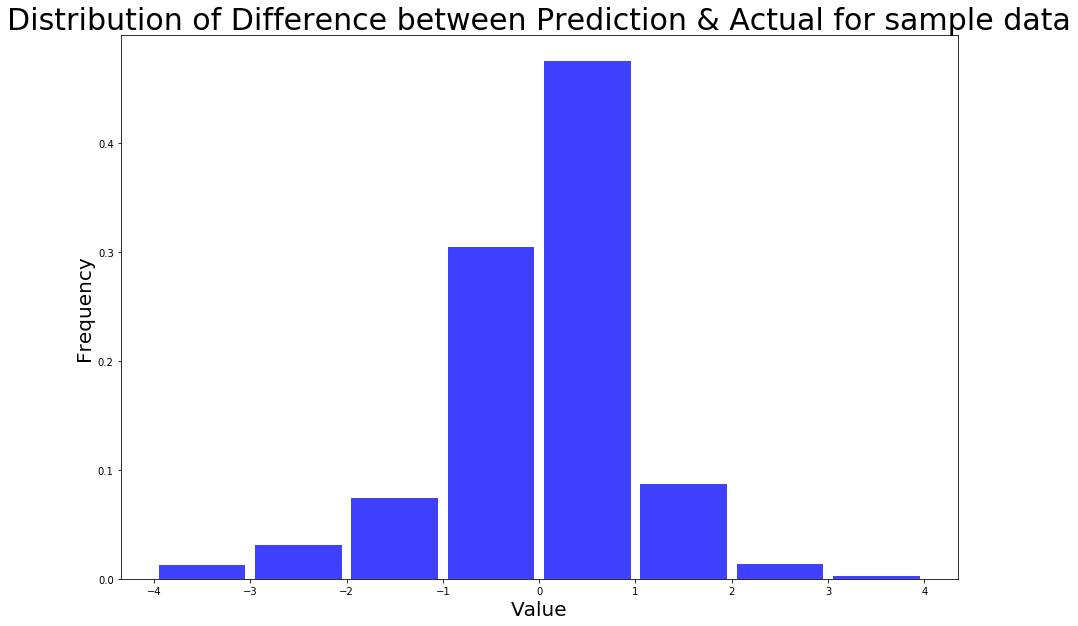

In [49]:
model_pred(AAPL_ITM, model_ITM, 'realized_vol')

,predict,actual
0,2.748216,2.79
1,1.946559,2.06
2,1.366686,1.43
3,1.159245,0.93
4,0.782624,0.56
5,0.437569,0.32
6,0.200147,0.61
7,0.377600,0.88
8,0.675651,1.25
9,1.524710,1.76


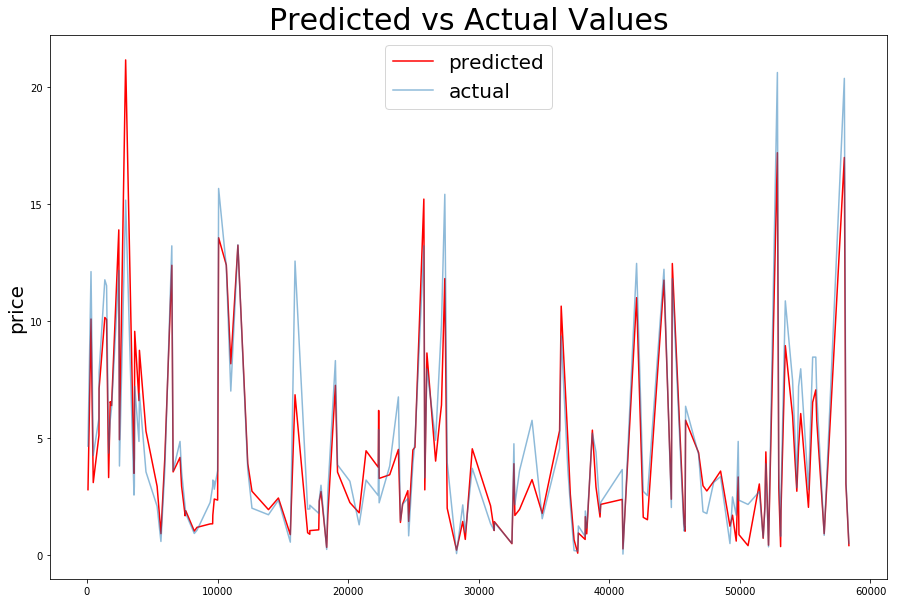

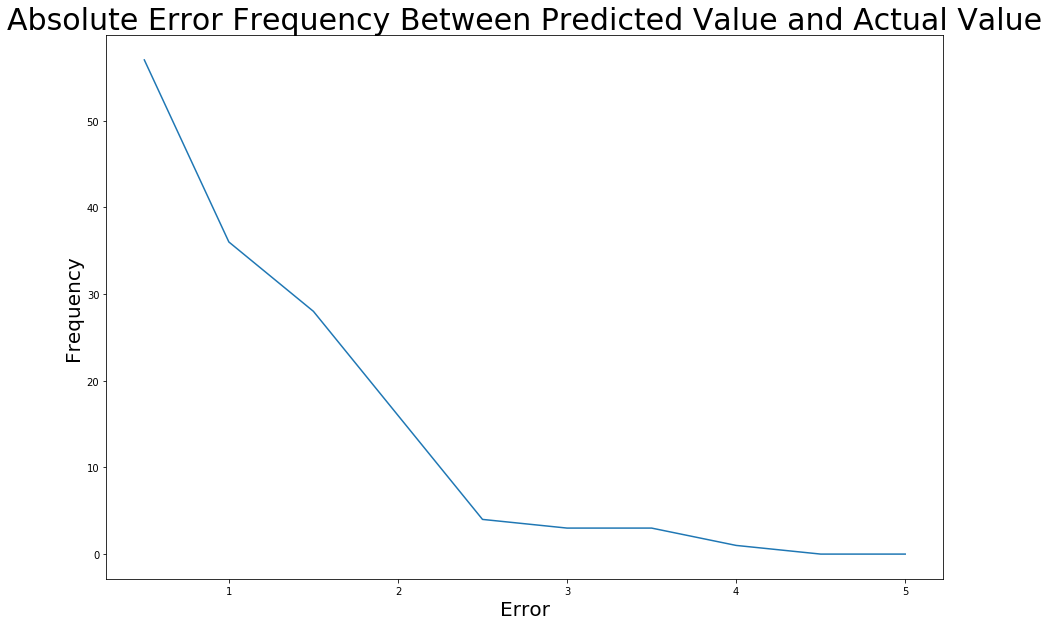

Mean absolute error (MAE):      0.897570
Mean squared error (MSE):       1.509940
R square (R^2):                 0.913917


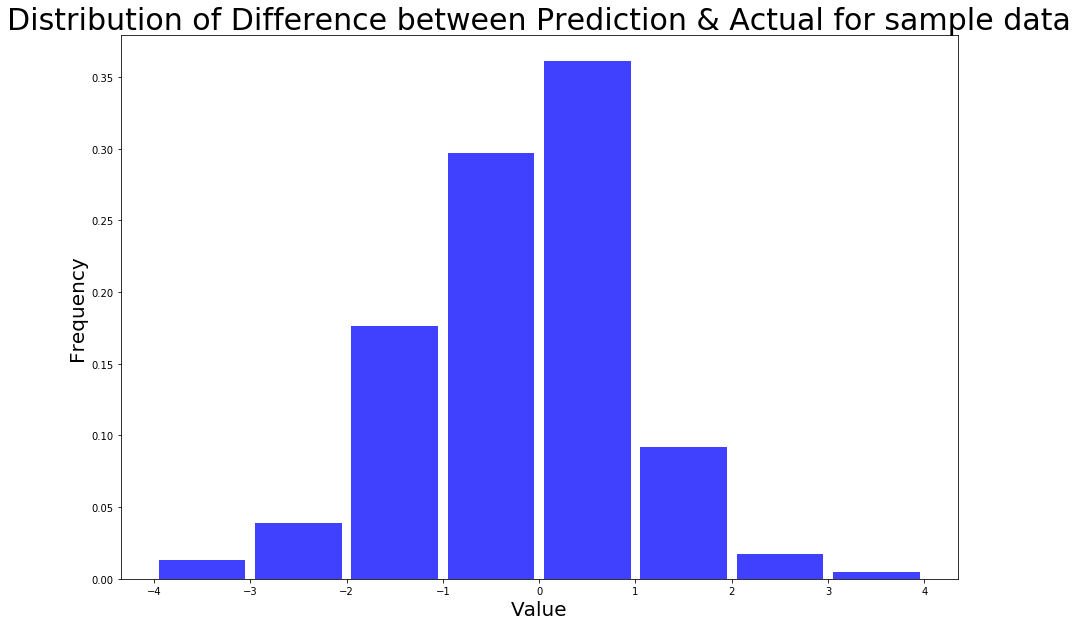

In [50]:
model_pred(AAPL_ATM, model_ATM, 'realized_vol')

,predict,actual
0,5.447069,5.45
1,4.481031,4.50
2,3.542819,3.65
3,6.428174,6.45
4,0.084785,0.23
5,0.096593,0.31
6,0.145872,0.43
7,1.131845,0.02
8,1.081102,0.02
9,0.971653,0.02


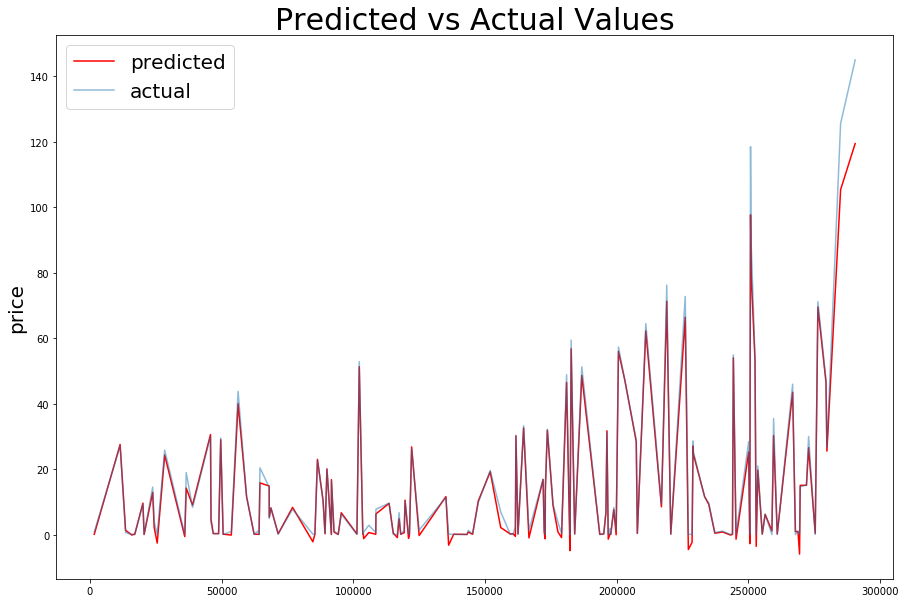

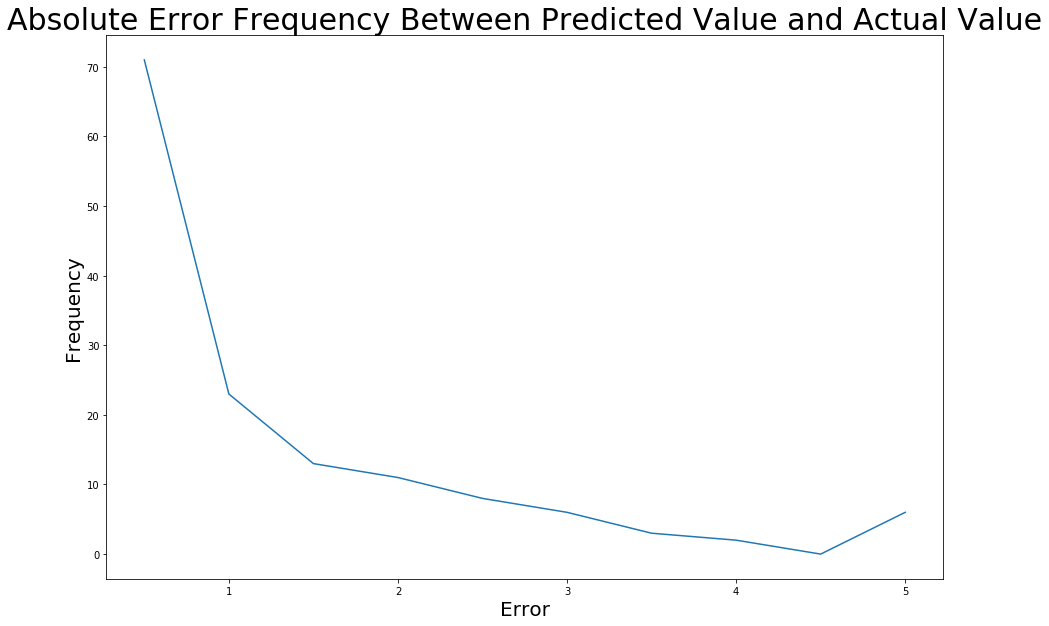

Mean absolute error (MAE):      1.499661
Mean squared error (MSE):       11.305378
R square (R^2):                 0.982494


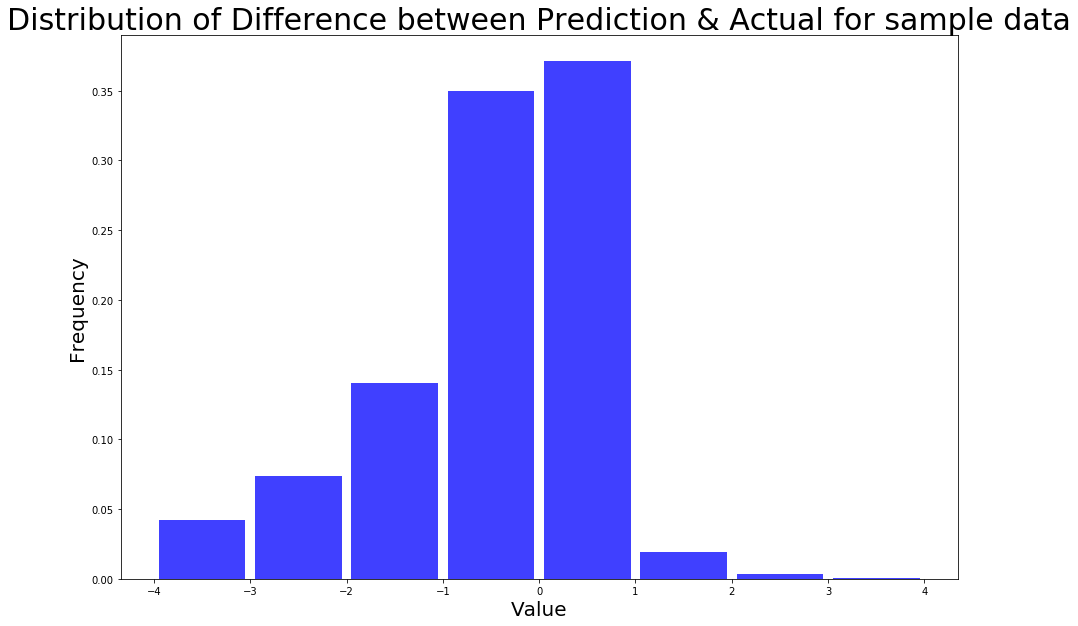

In [51]:
model_pred(AAPL_OTM, model_OTM, 'realized_vol')

,predict,actual
0,5.703896,5.45
1,4.714864,4.50
2,3.747647,3.65
3,2.842242,2.79
4,1.982154,2.06
5,1.198372,1.43
6,0.770332,0.93
7,0.454865,0.56
8,0.312562,0.32
9,0.169252,0.18


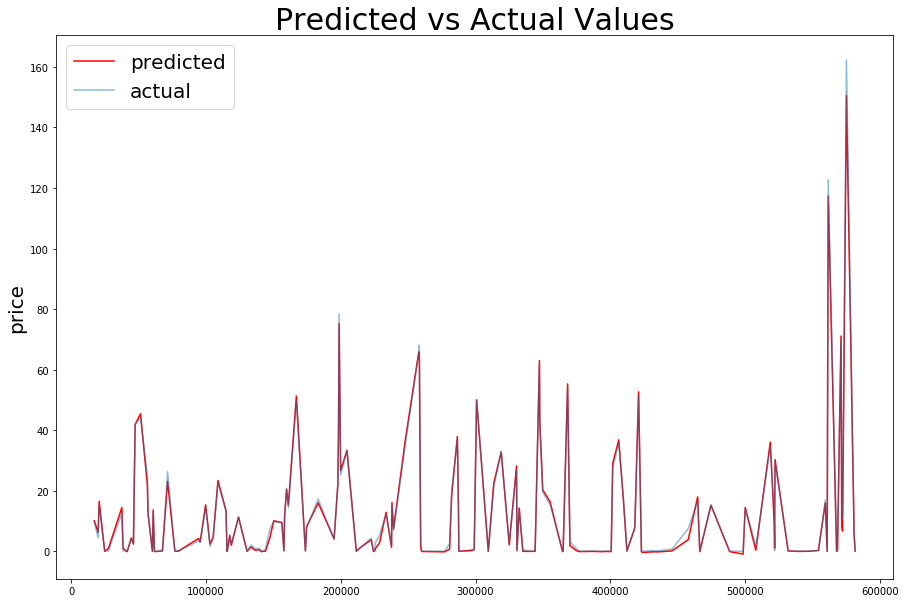

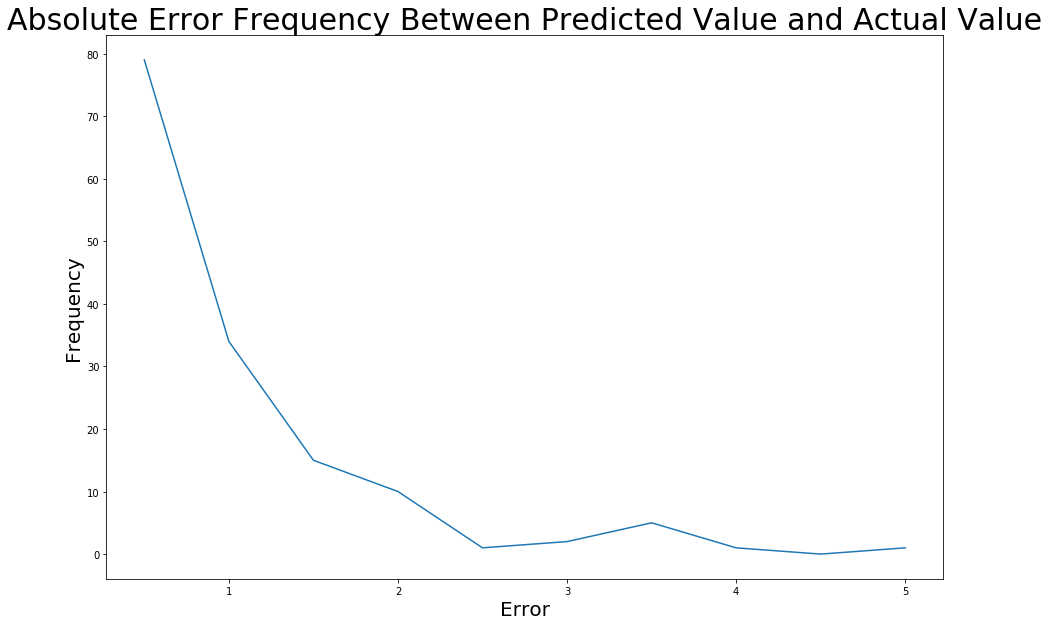

Mean absolute error (MAE):      0.816380
Mean squared error (MSE):       1.917326
R square (R^2):                 0.996892


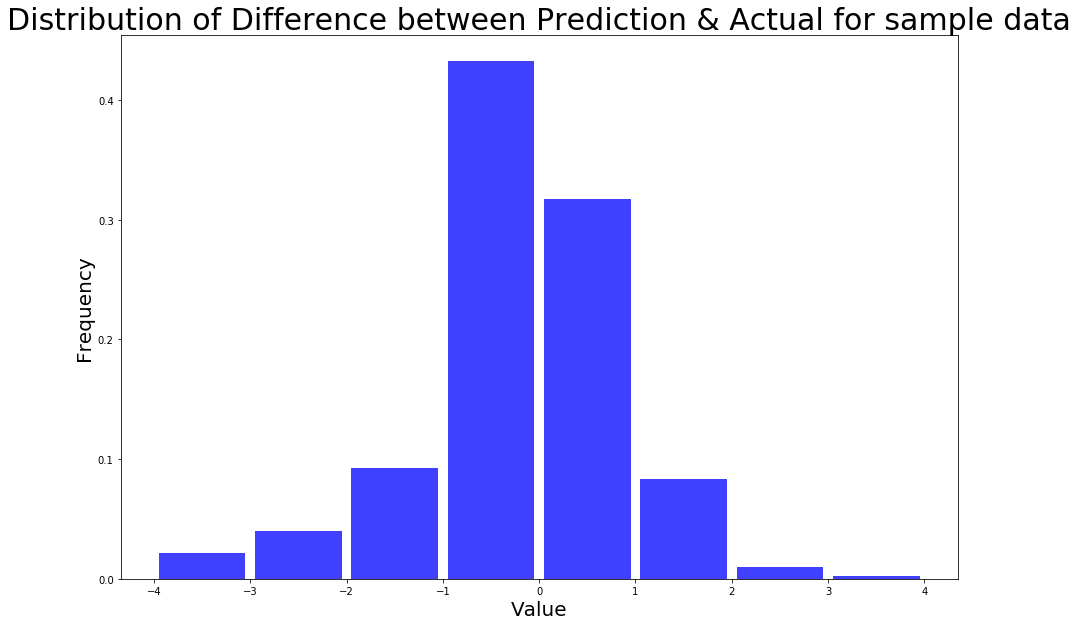

In [52]:
model_pred(AAPL, model, 'realized_vol')

## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>